# Previsão do Preço do Bitcoin com LSTM
 
**Framework:** TensorFlow/Keras

**Requerimentos:** 

    1.Python 3.9
    2.Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
    3.Pandas
    4.Matplotlib
    5.Baixar o dataset no local: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

## Etapas do Projeto:
    1. Carregamento e Exploração dos Dados
    2. Pré-processamento
    3. Criação do Modelo LSTM
    4. Treinamento e Validação
    5. Avaliação e Previsões




# Importação de Bibliotecas

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score 

# 1. Carregamento e Exploração dos Dados

In [77]:
# Carregar o arquivo CSV (ajuste o caminho conforme necessário)
df = pd.read_csv('btcusd_1-min_data.csv')

In [78]:
df

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6750276,1.737936e+09,102628.00,102669.00,102608.00,102611.00,0.086742
6750277,1.737936e+09,102659.00,102712.00,102657.00,102712.00,0.488757
6750278,1.737936e+09,102631.00,102631.00,102573.00,102573.00,0.126719
6750279,1.737936e+09,102573.00,102604.00,102507.00,102514.00,0.474495


In [79]:
# Converter timestamp para datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume,date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [80]:

print("\nInformações do Dataset:")
df.info()


Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750281 entries, 0 to 6750280
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  float64       
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
 6   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 360.5 MB


## Pré-processamento Inicial

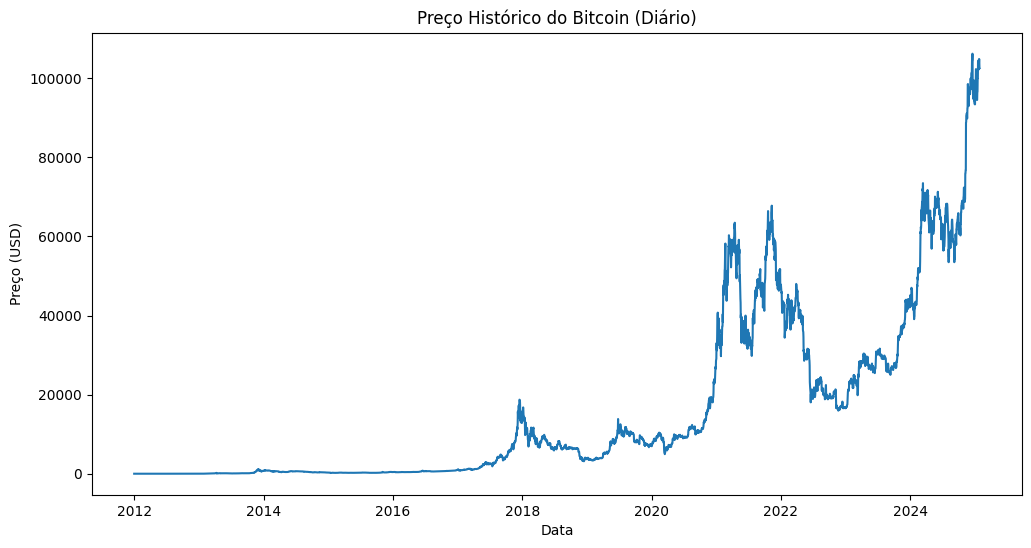

In [81]:
# Converter dados de 1 minuto para diários
df_daily = df.resample('D', on='date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    
}).dropna()

# Plot do preço de fechamento
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily['Close'])
plt.title('Preço Histórico do Bitcoin (Diário)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.show()

# 2. Pré-processamento para LSTM

In [90]:
# Usaremos apenas o preço de fechamento
data = df_daily[['Close']].values

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Divisão entre treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [91]:
# Função para criar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Janela temporal de 60 dias
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

In [92]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# 3. Utilização do Opituna para testar variações:

In [49]:
def objective(trial):
    # Sugerir o número de camadas LSTM (entre 1 e 3)
    n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 3)
    
    model = Sequential()
    
    # Adicionar as camadas LSTM dinamicamente
    for i in range(n_lstm_layers):
        lstm_units = trial.suggest_int(f"lstm_units_{i}", 25, 200, step=10)
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
        return_sequences = (i < n_lstm_layers - 1)
        
        if i == 0:
            model.add(LSTM(lstm_units, return_sequences=return_sequences, input_shape=(SEQ_LENGTH, 1)))
        else:
            model.add(LSTM(lstm_units, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))
    
    # Camada Dense intermediária
    dense_units = trial.suggest_int('dense_units', 10, 100, step=10)
    model.add(Dense(dense_units, activation='relu'))
    
    # Camada de saída
    model.add(Dense(1))
    
    # Outros hiperparâmetros
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,            # Usando 100 épocas para acelerar os trials
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Obter o menor valor de loss da validação
    val_loss = min(history.history['val_loss'])
    
    # Calcular a precisão (R² score) no conjunto de teste
    y_pred = model.predict(X_test)
    test_accuracy = r2_score(y_test, y_pred)
    
    # Salvar a precisão no trial para que seja exportada junto com os demais parâmetros
    trial.set_user_attr("test_accuracy", test_accuracy)
    
    return val_loss

# Criar estudo e executar os trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

# Exibir o melhor trial encontrado
print("Melhor Trial:")
print("Parâmetros:", study.best_trial.params)
print("Validação Loss:", study.best_trial.value)
print("Precisão (R²) no conjunto de teste:", study.best_trial.user_attrs["test_accuracy"])

# Gerar DataFrame com os resultados dos trials (a coluna 'user_attrs_test_accuracy' aparecerá)
df_trials = study.trials_dataframe()

# Salvar em Excel (certifique-se de ter o pacote 'openpyxl' instalado)
df_trials.to_excel("optuna_results.xlsx", index=False)
print("Resultados do Optuna salvos no arquivo 'optuna_results.xlsx'.")

[I 2025-02-08 16:44:30,096] A new study created in memory with name: no-name-b737a8d5-071b-457b-b20c-bf36bbc67b82


/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
24/24 [==============================] - 5s 53ms/step - loss: 5.1663e-04 - val_loss: 0.0046
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 1.1955e-04 - val_loss: 0.0058
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 1.0155e-04 - val_loss: 0.0062
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 7.7383e-05 - val_loss: 0.0064
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 7.1430e-05 - val_loss: 0.0081
Epoch 6/100
24/24 [==============================] - 0s 17ms/step - loss: 6.6120e-05 - val_loss: 0.0112
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 6.9322e-05 - val_loss: 0.0095
Epoch 8/100
24/24 [==============================] - 0s 17ms/step - loss: 6.2107e-05 - val_loss: 0.0076
Epoch 9/100
28/28 [==============================] - 1s 4ms/step


[I 2025-02-08 16:44:39,743] Trial 0 finished with value: 0.004629242233932018 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 115, 'dropout_rate_0': 0.2, 'lstm_units_1': 65, 'dropout_rate_1': 0.5, 'lstm_units_2': 55, 'dropout_rate_2': 0.5, 'dense_units': 30, 'batch_size': 128, 'learning_rate': 0.001523040447570067}. Best is trial 0 with value: 0.004629242233932018.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
38/38 [==============================] - 5s 44ms/step - loss: 3.1133e-04 - val_loss: 0.0021
Epoch 2/100
38/38 [==============================] - 1s 17ms/step - loss: 6.5873e-05 - val_loss: 0.0039
Epoch 3/100
38/38 [==============================] - 1s 17ms/step - loss: 6.2038e-05 - val_loss: 0.0036
Epoch 4/100
38/38 [==============================] - 1s 18ms/step - loss: 5.3878e-05 - val_loss: 0.0035
Epoch 5/100
38/38 [==============================] - 1s 17ms/step - loss: 4.9872e-05 - val_loss: 0.0053
Epoch 6/100
38/38 [==============================] - 1s 17ms/step - loss: 4.7543e-05 - val_loss: 0.0021
Epoch 7/100
38/38 [==============================] - 1s 16ms/step - loss: 4.8695e-05 - val_loss: 0.0041
Epoch 8/100
38/38 [==============================] - 1s 17ms/step - loss: 4.4509e-05 - val_loss: 0.0055
Epoch 9/100
28/28 [==============================] - 1s 4ms/step


[I 2025-02-08 16:44:52,169] Trial 1 finished with value: 0.002121981233358383 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 75, 'dropout_rate_0': 0.4, 'lstm_units_1': 135, 'dropout_rate_1': 0.5, 'lstm_units_2': 115, 'dropout_rate_2': 0.2, 'dense_units': 80, 'batch_size': 80, 'learning_rate': 0.00031482851804085226}. Best is trial 1 with value: 0.002121981233358383.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 6s 13ms/step - loss: 1.1700e-04 - val_loss: 8.3160e-04
Epoch 2/100
188/188 [==============================] - 2s 8ms/step - loss: 5.3578e-05 - val_loss: 9.2220e-04
Epoch 3/100
188/188 [==============================] - 1s 8ms/step - loss: 4.1007e-05 - val_loss: 0.0044
Epoch 4/100
188/188 [==============================] - 1s 8ms/step - loss: 4.3228e-05 - val_loss: 0.0047
Epoch 5/100
188/188 [==============================] - 1s 8ms/step - loss: 4.0518e-05 - val_loss: 0.0028
Epoch 6/100
188/188 [==============================] - 1s 8ms/step - loss: 3.3366e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 8ms/step - loss: 3.6089e-05 - val_loss: 0.0016
Epoch 8/100
188/188 [==============================] - 1s 8ms/step - loss: 3.3285e-05 - val_loss: 0.0036
Epoch 9/100
28/28 [==============================] - 1s 3ms/step


[I 2025-02-08 16:45:12,316] Trial 2 finished with value: 0.0008315996965393424 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 145, 'dropout_rate_0': 0.2, 'lstm_units_1': 125, 'dropout_rate_1': 0.5, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0009434725434580055}. Best is trial 2 with value: 0.0008315996965393424.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 2s 10ms/step - loss: 6.0468e-04 - val_loss: 0.0122
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 4.8119e-05 - val_loss: 0.0040
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 4.3486e-05 - val_loss: 0.0034
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 4.1965e-05 - val_loss: 0.0030
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 3.8335e-05 - val_loss: 0.0028
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 3.7600e-05 - val_loss: 0.0033
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 3.4195e-05 - val_loss: 0.0023
Epoch 8/100
94/94 [==============================] - 1s 5ms/step - loss: 3.2932e-05 - val_loss: 0.0026
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 3.0720e-05 - val_loss: 0.0025
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss

[I 2025-02-08 16:45:32,591] Trial 3 finished with value: 0.0012392773060128093 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 20, 'batch_size': 32, 'learning_rate': 4.231469368490723e-05}. Best is trial 2 with value: 0.0008315996965393424.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
38/38 [==============================] - 2s 16ms/step - loss: 6.3827e-04 - val_loss: 0.0081
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 8.2990e-05 - val_loss: 0.0067
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 6.2050e-05 - val_loss: 0.0041
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 5.8138e-05 - val_loss: 0.0039
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 4.7374e-05 - val_loss: 0.0049
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 4.4332e-05 - val_loss: 0.0040
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 4.4631e-05 - val_loss: 0.0046
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 3.7231e-05 - val_loss: 0.0041
Epoch 9/100
38/38 [==============================] - 0s 5ms/step - loss: 4.2230e-05 - val_loss: 0.0044
Epoch 10/100
38/38 [==============================] - 0s 6ms/step - loss

[I 2025-02-08 16:45:42,798] Trial 4 finished with value: 0.0019223493291065097 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 65, 'dropout_rate_0': 0.5, 'dense_units': 70, 'batch_size': 80, 'learning_rate': 0.0003044226641988735}. Best is trial 2 with value: 0.0008315996965393424.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 2s 10ms/step - loss: 1.9270e-04 - val_loss: 0.0040
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 4.5170e-05 - val_loss: 0.0039
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 3.5139e-05 - val_loss: 0.0022
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 3.8054e-05 - val_loss: 0.0028
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 3.1386e-05 - val_loss: 0.0031
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 3.1316e-05 - val_loss: 0.0026
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 2.7396e-05 - val_loss: 0.0020
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 3.1638e-05 - val_loss: 0.0010
Epoch 9/100
63/63 [==============================] - 0s 5ms/step - loss: 2.8062e-05 - val_loss: 0.0030
Epoch 10/100
63/63 [==============================] - 0s 5ms/step - loss

[I 2025-02-08 16:45:50,602] Trial 5 finished with value: 0.0006706675630994141 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 45, 'dropout_rate_0': 0.4, 'dense_units': 20, 'batch_size': 48, 'learning_rate': 0.006270473123538873}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
47/47 [==============================] - 6s 34ms/step - loss: 0.0014 - val_loss: 0.0919
Epoch 2/100
47/47 [==============================] - 1s 13ms/step - loss: 7.7902e-04 - val_loss: 0.0591
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: 4.4060e-04 - val_loss: 0.0354
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: 2.2379e-04 - val_loss: 0.0183
Epoch 5/100
47/47 [==============================] - 1s 12ms/step - loss: 1.0989e-04 - val_loss: 0.0079
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 7.1858e-05 - val_loss: 0.0052
Epoch 7/100
47/47 [==============================] - 1s 12ms/step - loss: 6.9394e-05 - val_loss: 0.0045
Epoch 8/100
47/47 [==============================] - 1s 12ms/step - loss: 6.6684e-05 - val_loss: 0.0044
Epoch 9/100
47/47 [==============================] - 1s 12ms/step - loss: 6.4284e-05 - val_loss: 0.0045
Epoch 10/100
47/47 [==============================] - 1s 12ms/step -

[I 2025-02-08 16:46:34,649] Trial 6 finished with value: 0.0017914229538291693 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 135, 'dropout_rate_0': 0.5, 'lstm_units_1': 135, 'dropout_rate_1': 0.30000000000000004, 'dense_units': 20, 'batch_size': 64, 'learning_rate': 1.282938354633476e-05}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
47/47 [==============================] - 6s 36ms/step - loss: 2.5828e-04 - val_loss: 0.0111
Epoch 2/100
47/47 [==============================] - 1s 11ms/step - loss: 8.9058e-05 - val_loss: 0.0116
Epoch 3/100
47/47 [==============================] - 0s 11ms/step - loss: 5.9829e-05 - val_loss: 0.0106
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: 5.8541e-05 - val_loss: 0.0097
Epoch 5/100
47/47 [==============================] - 1s 11ms/step - loss: 5.5614e-05 - val_loss: 0.0079
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: 5.0291e-05 - val_loss: 0.0078
Epoch 7/100
47/47 [==============================] - 1s 11ms/step - loss: 4.8815e-05 - val_loss: 0.0047
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: 4.6171e-05 - val_loss: 0.0086
Epoch 9/100
47/47 [==============================] - 1s 11ms/step - loss: 4.5843e-05 - val_loss: 0.0063
Epoch 10/100
47/47 [==============================] - 1s 11ms/st

[I 2025-02-08 16:46:53,010] Trial 7 finished with value: 0.0035076714120805264 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 45, 'dropout_rate_0': 0.5, 'lstm_units_1': 85, 'dropout_rate_1': 0.5, 'lstm_units_2': 35, 'dropout_rate_2': 0.2, 'dense_units': 80, 'batch_size': 64, 'learning_rate': 0.0008381431851765466}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
38/38 [==============================] - 8s 48ms/step - loss: 0.0013 - val_loss: 0.0849
Epoch 2/100
38/38 [==============================] - 1s 14ms/step - loss: 7.9542e-04 - val_loss: 0.0638
Epoch 3/100
38/38 [==============================] - 1s 14ms/step - loss: 6.0929e-04 - val_loss: 0.0480
Epoch 4/100
38/38 [==============================] - 1s 15ms/step - loss: 4.6879e-04 - val_loss: 0.0320
Epoch 5/100
38/38 [==============================] - 1s 14ms/step - loss: 2.9754e-04 - val_loss: 0.0167
Epoch 6/100
38/38 [==============================] - 1s 14ms/step - loss: 1.7761e-04 - val_loss: 0.0068
Epoch 7/100
38/38 [==============================] - 1s 14ms/step - loss: 1.1753e-04 - val_loss: 0.0035
Epoch 8/100
38/38 [==============================] - 1s 14ms/step - loss: 1.1624e-04 - val_loss: 0.0029
Epoch 9/100
38/38 [==============================] - 1s 14ms/step - loss: 1.0433e-04 - val_loss: 0.0028
Epoch 10/100
38/38 [==============================] - 1s 15ms/step -

[I 2025-02-08 16:47:15,498] Trial 8 finished with value: 0.0027157170698046684 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 105, 'dropout_rate_0': 0.2, 'lstm_units_1': 75, 'dropout_rate_1': 0.4, 'lstm_units_2': 75, 'dropout_rate_2': 0.4, 'dense_units': 30, 'batch_size': 80, 'learning_rate': 1.4436238951470903e-05}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
24/24 [==============================] - 6s 54ms/step - loss: 8.6972e-04 - val_loss: 0.0259
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 1.2860e-04 - val_loss: 0.0207
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 8.5464e-05 - val_loss: 0.0124
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 7.9152e-05 - val_loss: 0.0113
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 7.2680e-05 - val_loss: 0.0112
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 6.9237e-05 - val_loss: 0.0108
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 7.0036e-05 - val_loss: 0.0103
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 6.5248e-05 - val_loss: 0.0077
Epoch 9/100
24/24 [==============================] - 0s 13ms/step - loss: 6.0914e-05 - val_loss: 0.0075
Epoch 10/100
24/24 [==============================] - 0s 13ms/st

[I 2025-02-08 16:47:29,552] Trial 9 finished with value: 0.005043409764766693 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 65, 'dropout_rate_0': 0.1, 'lstm_units_1': 45, 'dropout_rate_1': 0.2, 'lstm_units_2': 35, 'dropout_rate_2': 0.2, 'dense_units': 100, 'batch_size': 128, 'learning_rate': 0.0002853738097990516}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 2s 9ms/step - loss: 1.8413e-04 - val_loss: 0.0140
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 5.6001e-05 - val_loss: 0.0091
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 4.9745e-05 - val_loss: 0.0022
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 4.7678e-05 - val_loss: 0.0110
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 4.4919e-05 - val_loss: 0.0133
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 4.5076e-05 - val_loss: 0.0066
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 5.0159e-05 - val_loss: 0.0081
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 3.4571e-05 - val_loss: 0.0045
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 3.7359e-05 - val_loss: 0.0033
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss:

[I 2025-02-08 16:47:37,095] Trial 10 finished with value: 0.002162574091926217 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 25, 'dropout_rate_0': 0.4, 'dense_units': 50, 'batch_size': 32, 'learning_rate': 0.007268663076668977}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 7s 14ms/step - loss: 3.9804e-04 - val_loss: 0.0117
Epoch 2/100
188/188 [==============================] - 2s 10ms/step - loss: 5.3941e-05 - val_loss: 0.0193
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 4.4695e-05 - val_loss: 0.0050
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 2.9974e-05 - val_loss: 0.0089
Epoch 5/100
188/188 [==============================] - 2s 10ms/step - loss: 2.7701e-05 - val_loss: 0.0037
Epoch 6/100
188/188 [==============================] - 2s 10ms/step - loss: 2.5235e-05 - val_loss: 0.0069
Epoch 7/100
188/188 [==============================] - 2s 10ms/step - loss: 2.6668e-05 - val_loss: 0.0028
Epoch 8/100
188/188 [==============================] - 2s 10ms/step - loss: 2.4460e-05 - val_loss: 0.0026
Epoch 9/100
188/188 [==============================] - 2s 10ms/step - loss: 2.5045e-05 - val_loss: 8.5999e-04
Epoch 10/100
188/188 [======================

[I 2025-02-08 16:48:14,787] Trial 11 finished with value: 0.0008599882712587714 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 165, 'dropout_rate_0': 0.30000000000000004, 'lstm_units_1': 195, 'dropout_rate_1': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.007873741099587042}. Best is trial 5 with value: 0.0006706675630994141.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 6s 13ms/step - loss: 9.4320e-05 - val_loss: 0.0043
Epoch 2/100
188/188 [==============================] - 2s 9ms/step - loss: 4.6005e-05 - val_loss: 6.1129e-04
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 4.1206e-05 - val_loss: 0.0070
Epoch 4/100
188/188 [==============================] - 2s 10ms/step - loss: 3.4921e-05 - val_loss: 0.0013
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 3.3758e-05 - val_loss: 0.0047
Epoch 6/100
188/188 [==============================] - 2s 9ms/step - loss: 2.8385e-05 - val_loss: 0.0015
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 2.8074e-05 - val_loss: 0.0050
Epoch 8/100
188/188 [==============================] - 2s 9ms/step - loss: 2.7302e-05 - val_loss: 0.0026
Epoch 9/100
188/188 [==============================] - 2s 9ms/step - loss: 2.5155e-05 - val_loss: 0.0062
Epoch 10/100
188/188 [===========================

[I 2025-02-08 16:48:51,266] Trial 12 finished with value: 0.00044917731429450214 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 155, 'dropout_rate_0': 0.30000000000000004, 'lstm_units_1': 185, 'dropout_rate_1': 0.30000000000000004, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002172847818984488}. Best is trial 12 with value: 0.00044917731429450214.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 3s 14ms/step - loss: 1.1609e-04 - val_loss: 0.0028
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 3.4382e-05 - val_loss: 9.2043e-04
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 2.9944e-05 - val_loss: 0.0037
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 2.9484e-05 - val_loss: 0.0031
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 2.8242e-05 - val_loss: 0.0034
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 2.5650e-05 - val_loss: 0.0025
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 2.5602e-05 - val_loss: 0.0037
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 2.4285e-05 - val_loss: 0.0019
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 2.8995e-05 - val_loss: 0.0016
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - 

[I 2025-02-08 16:49:03,429] Trial 13 finished with value: 0.0004610040341503918 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.4, 'dense_units': 10, 'batch_size': 48, 'learning_rate': 0.0029913799718011866}. Best is trial 12 with value: 0.00044917731429450214.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 5s 31ms/step - loss: 4.3301e-04 - val_loss: 0.0036
Epoch 2/100
63/63 [==============================] - 1s 17ms/step - loss: 5.5479e-05 - val_loss: 0.0041
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 3.1409e-05 - val_loss: 0.0028
Epoch 4/100
63/63 [==============================] - 1s 20ms/step - loss: 3.1167e-05 - val_loss: 0.0015
Epoch 5/100
63/63 [==============================] - 1s 17ms/step - loss: 3.3092e-05 - val_loss: 0.0029
Epoch 6/100
63/63 [==============================] - 1s 17ms/step - loss: 3.3931e-05 - val_loss: 0.0049
Epoch 7/100
63/63 [==============================] - 1s 17ms/step - loss: 2.8474e-05 - val_loss: 0.0058
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 2.5503e-05 - val_loss: 0.0024
Epoch 9/100
63/63 [==============================] - 1s 17ms/step - loss: 2.1118e-05 - val_loss: 0.0058
Epoch 10/100
63/63 [==============================] - 1s 17ms/st

[I 2025-02-08 16:49:22,246] Trial 14 finished with value: 0.0014968381728976965 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 195, 'dropout_rate_0': 0.30000000000000004, 'lstm_units_1': 195, 'dropout_rate_1': 0.30000000000000004, 'dense_units': 60, 'batch_size': 48, 'learning_rate': 0.0024573320461247863}. Best is trial 12 with value: 0.00044917731429450214.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 6s 19ms/step - loss: 1.2120e-04 - val_loss: 7.0688e-04
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 3.8388e-05 - val_loss: 9.0206e-04
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 2.9297e-05 - val_loss: 0.0010
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 2.6304e-05 - val_loss: 9.4474e-04
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 2.6820e-05 - val_loss: 8.2607e-04
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 2.2577e-05 - val_loss: 7.5282e-04
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 2.6743e-05 - val_loss: 3.5800e-04
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 2.4953e-05 - val_loss: 0.0017
Epoch 9/100
94/94 [==============================] - 1s 8ms/step - loss: 2.5898e-05 - val_loss: 0.0014
Epoch 10/100
94/94 [============================

[I 2025-02-08 16:49:38,002] Trial 15 finished with value: 0.0003580041229724884 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.4, 'dense_units': 10, 'batch_size': 32, 'learning_rate': 0.002470918239446909}. Best is trial 15 with value: 0.0003580041229724884.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 7s 14ms/step - loss: 1.6345e-04 - val_loss: 0.0050
Epoch 2/100
188/188 [==============================] - 2s 9ms/step - loss: 4.6578e-05 - val_loss: 0.0045
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 3.8584e-05 - val_loss: 0.0029
Epoch 4/100
188/188 [==============================] - 2s 10ms/step - loss: 3.5648e-05 - val_loss: 0.0029
Epoch 5/100
188/188 [==============================] - 2s 10ms/step - loss: 2.9274e-05 - val_loss: 0.0014
Epoch 6/100
188/188 [==============================] - 2s 11ms/step - loss: 2.9844e-05 - val_loss: 0.0018
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 2.6325e-05 - val_loss: 0.0025
Epoch 8/100
188/188 [==============================] - 2s 10ms/step - loss: 2.5382e-05 - val_loss: 0.0020
Epoch 9/100
188/188 [==============================] - 2s 12ms/step - loss: 2.5228e-05 - val_loss: 0.0023
Epoch 10/100
188/188 [===========================

[I 2025-02-08 16:50:20,572] Trial 16 finished with value: 0.000734131142962724 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 135, 'dropout_rate_0': 0.30000000000000004, 'lstm_units_1': 165, 'dropout_rate_1': 0.2, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 9.82404105607651e-05}. Best is trial 15 with value: 0.0003580041229724884.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 9.8872e-05 - val_loss: 0.0017
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 2.2526e-05 - val_loss: 0.0022
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 1.9748e-05 - val_loss: 0.0019
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.7377e-05 - val_loss: 0.0011
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6763e-05 - val_loss: 0.0025
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5804e-05 - val_loss: 0.0021
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4007e-05 - val_loss: 0.0015
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.2138e-05 - val_loss: 0.0011
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4299e-05 - val_loss: 0.0017
Epoch 10/100
94/94 [==============================] - 1s 7ms/step - loss

[I 2025-02-08 16:50:35,787] Trial 17 finished with value: 0.0003445916809141636 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 32, 'learning_rate': 0.0007154919196287709}. Best is trial 17 with value: 0.0003445916809141636.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
32/32 [==============================] - 2s 23ms/step - loss: 1.6759e-04 - val_loss: 8.9846e-04
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 2.5053e-05 - val_loss: 0.0011
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 2.0598e-05 - val_loss: 0.0011
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 1.9044e-05 - val_loss: 0.0026
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 1.8928e-05 - val_loss: 0.0015
Epoch 6/100
32/32 [==============================] - 0s 11ms/step - loss: 1.6964e-05 - val_loss: 0.0017
Epoch 7/100
32/32 [==============================] - 0s 11ms/step - loss: 1.6579e-05 - val_loss: 0.0019
Epoch 8/100
32/32 [==============================] - 0s 11ms/step - loss: 1.6236e-05 - val_loss: 0.0017
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 16:50:41,811] Trial 18 finished with value: 0.0008984602754935622 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 96, 'learning_rate': 0.000785946538893062}. Best is trial 17 with value: 0.0003445916809141636.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 4s 10ms/step - loss: 9.3292e-04 - val_loss: 0.0136
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 5.1077e-05 - val_loss: 0.0091
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 4.5870e-05 - val_loss: 0.0090
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 4.0778e-05 - val_loss: 0.0074
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 3.7960e-05 - val_loss: 0.0056
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 3.3726e-05 - val_loss: 0.0061
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 3.1502e-05 - val_loss: 0.0040
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 3.0766e-05 - val_loss: 0.0035
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 2.7723e-05 - val_loss: 0.0035
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss

[I 2025-02-08 16:51:00,261] Trial 19 finished with value: 0.0015574852004647255 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 125, 'dropout_rate_0': 0.1, 'dense_units': 10, 'batch_size': 32, 'learning_rate': 0.00011369677028169538}. Best is trial 17 with value: 0.0003445916809141636.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
27/27 [==============================] - 3s 29ms/step - loss: 3.5389e-04 - val_loss: 0.0020
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 5.1487e-05 - val_loss: 0.0011
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 4.3650e-05 - val_loss: 0.0014
Epoch 4/100
27/27 [==============================] - 0s 8ms/step - loss: 3.8247e-05 - val_loss: 0.0019
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 3.2550e-05 - val_loss: 0.0014
Epoch 6/100
27/27 [==============================] - 0s 8ms/step - loss: 3.2270e-05 - val_loss: 0.0012
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 3.0826e-05 - val_loss: 0.0014
Epoch 8/100
27/27 [==============================] - 0s 8ms/step - loss: 2.8829e-05 - val_loss: 0.0013
Epoch 9/100
27/27 [==============================] - 0s 8ms/step - loss: 2.3948e-05 - val_loss: 0.0013
Epoch 10/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 16:51:05,919] Trial 20 finished with value: 0.0011001786915585399 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.4, 'dense_units': 40, 'batch_size': 112, 'learning_rate': 0.0005703164433730285}. Best is trial 17 with value: 0.0003445916809141636.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 5s 20ms/step - loss: 1.6144e-04 - val_loss: 0.0020
Epoch 2/100
94/94 [==============================] - 1s 10ms/step - loss: 2.8432e-05 - val_loss: 7.7255e-04
Epoch 3/100
94/94 [==============================] - 1s 11ms/step - loss: 4.0161e-05 - val_loss: 0.0011
Epoch 4/100
94/94 [==============================] - 1s 11ms/step - loss: 2.4333e-05 - val_loss: 0.0011
Epoch 5/100
94/94 [==============================] - 1s 10ms/step - loss: 2.9947e-05 - val_loss: 0.0017
Epoch 6/100
94/94 [==============================] - 1s 11ms/step - loss: 2.0177e-05 - val_loss: 0.0014
Epoch 7/100
94/94 [==============================] - 1s 11ms/step - loss: 2.5051e-05 - val_loss: 0.0012
Epoch 8/100
94/94 [==============================] - 1s 11ms/step - loss: 2.1731e-05 - val_loss: 0.0022
Epoch 9/100
94/94 [==============================] - 1s 10ms/step - loss: 1.9340e-05 - val_loss: 0.0014
Epoch 10/100
28/28 [==============================] - 1s 3ms

[I 2025-02-08 16:51:21,537] Trial 21 finished with value: 0.000772546511143446 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 155, 'dropout_rate_0': 0.30000000000000004, 'lstm_units_1': 165, 'dropout_rate_1': 0.1, 'dense_units': 60, 'batch_size': 32, 'learning_rate': 0.00267674240050898}. Best is trial 17 with value: 0.0003445916809141636.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.0162e-04 - val_loss: 4.9739e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7294e-05 - val_loss: 5.4779e-04
Epoch 3/100
188/188 [==============================] - 1s 7ms/step - loss: 2.2777e-05 - val_loss: 5.2103e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6616e-05 - val_loss: 0.0033
Epoch 5/100
188/188 [==============================] - 2s 8ms/step - loss: 2.1964e-05 - val_loss: 0.0024
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8704e-05 - val_loss: 0.0025
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1520e-05 - val_loss: 0.0017
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 2.3097e-05 - val_loss: 7.3833e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3643e-05 - val_loss: 2.9271e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 16:51:44,495] Trial 22 finished with value: 0.00029271241510286927 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.30000000000000004, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.0015751054162326107}. Best is trial 22 with value: 0.00029271241510286927.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 2s 13ms/step - loss: 1.3967e-04 - val_loss: 6.3668e-04
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 2.0297e-05 - val_loss: 5.7219e-04
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - loss: 1.9563e-05 - val_loss: 0.0015
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 1.7315e-05 - val_loss: 7.2302e-04
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 1.6335e-05 - val_loss: 6.1052e-04
Epoch 6/100
63/63 [==============================] - 0s 8ms/step - loss: 1.7627e-05 - val_loss: 4.0792e-04
Epoch 7/100
63/63 [==============================] - 0s 8ms/step - loss: 1.4536e-05 - val_loss: 4.3565e-04
Epoch 8/100
63/63 [==============================] - 0s 7ms/step - loss: 1.4863e-05 - val_loss: 6.7147e-04
Epoch 9/100
63/63 [==============================] - 0s 7ms/step - loss: 1.2970e-05 - val_loss: 3.3725e-04
Epoch 10/100
63/63 [====================

[I 2025-02-08 16:51:57,047] Trial 23 finished with value: 0.00030181973124854267 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.2, 'dense_units': 40, 'batch_size': 48, 'learning_rate': 0.0013413846249307115}. Best is trial 22 with value: 0.00029271241510286927.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 4s 17ms/step - loss: 1.6324e-04 - val_loss: 8.7731e-04
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 2.5531e-05 - val_loss: 6.8711e-04
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 2.2294e-05 - val_loss: 0.0010
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 1.8639e-05 - val_loss: 0.0019
Epoch 5/100
63/63 [==============================] - 1s 9ms/step - loss: 2.0008e-05 - val_loss: 0.0015
Epoch 6/100
63/63 [==============================] - 1s 9ms/step - loss: 1.8914e-05 - val_loss: 0.0015
Epoch 7/100
63/63 [==============================] - 1s 9ms/step - loss: 1.9718e-05 - val_loss: 0.0023
Epoch 8/100
63/63 [==============================] - 1s 9ms/step - loss: 1.6645e-05 - val_loss: 0.0015
Epoch 9/100
63/63 [==============================] - 1s 9ms/step - loss: 1.5068e-05 - val_loss: 0.0011
Epoch 10/100
28/28 [==============================] - 1s 2ms/ste

[I 2025-02-08 16:52:07,306] Trial 24 finished with value: 0.000687106978148222 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.2, 'dense_units': 40, 'batch_size': 48, 'learning_rate': 0.0005421868287464795}. Best is trial 22 with value: 0.00029271241510286927.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
47/47 [==============================] - 3s 20ms/step - loss: 1.0737e-04 - val_loss: 5.0689e-04
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 2.0567e-05 - val_loss: 7.1791e-04
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: 1.6114e-05 - val_loss: 5.9387e-04
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 2.2169e-05 - val_loss: 4.9845e-04
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 1.8995e-05 - val_loss: 0.0016
Epoch 6/100
47/47 [==============================] - 0s 8ms/step - loss: 1.4410e-05 - val_loss: 8.3355e-04
Epoch 7/100
47/47 [==============================] - 0s 9ms/step - loss: 1.2617e-05 - val_loss: 8.5130e-04
Epoch 8/100
47/47 [==============================] - 0s 9ms/step - loss: 1.4734e-05 - val_loss: 0.0018
Epoch 9/100
47/47 [==============================] - 0s 8ms/step - loss: 1.1165e-05 - val_loss: 0.0016
Epoch 10/100
47/47 [============================

[I 2025-02-08 16:52:15,140] Trial 25 finished with value: 0.0004984544357284904 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 64, 'learning_rate': 0.0012915765525172943}. Best is trial 22 with value: 0.00029271241510286927.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 3s 15ms/step - loss: 2.7009e-04 - val_loss: 0.0022
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 3.6421e-05 - val_loss: 0.0021
Epoch 3/100
63/63 [==============================] - 0s 7ms/step - loss: 3.0704e-05 - val_loss: 0.0022
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 2.6814e-05 - val_loss: 0.0026
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 2.5406e-05 - val_loss: 0.0024
Epoch 6/100
63/63 [==============================] - 0s 7ms/step - loss: 2.4087e-05 - val_loss: 0.0022
Epoch 7/100
63/63 [==============================] - 0s 7ms/step - loss: 2.2031e-05 - val_loss: 0.0015
Epoch 8/100
63/63 [==============================] - 0s 7ms/step - loss: 2.1685e-05 - val_loss: 0.0019
Epoch 9/100
63/63 [==============================] - 0s 8ms/step - loss: 1.9133e-05 - val_loss: 0.0021
Epoch 10/100
63/63 [==============================] - 0s 8ms/step - loss

[I 2025-02-08 16:52:33,344] Trial 26 finished with value: 0.0005568127380684018 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.2, 'dense_units': 50, 'batch_size': 48, 'learning_rate': 0.0001748686084722797}. Best is trial 22 with value: 0.00029271241510286927.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 7.0479e-05 - val_loss: 0.0027
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9520e-05 - val_loss: 6.8906e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8031e-05 - val_loss: 9.6759e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5437e-05 - val_loss: 0.0019
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8804e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4818e-05 - val_loss: 5.8340e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5163e-05 - val_loss: 5.2426e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8274e-05 - val_loss: 6.9692e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6354e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=============

[I 2025-02-08 16:53:02,896] Trial 27 finished with value: 0.00022865481150802225 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.004052148457832838}. Best is trial 27 with value: 0.00022865481150802225.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.6216e-04 - val_loss: 0.0025
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4140e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9546e-05 - val_loss: 8.2032e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0025e-05 - val_loss: 3.8351e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9803e-05 - val_loss: 3.3852e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9372e-05 - val_loss: 6.7859e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4353e-05 - val_loss: 9.5580e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6835e-05 - val_loss: 3.2832e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8611e-05 - val_loss: 2.6574e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 16:53:23,485] Trial 28 finished with value: 0.0002657405857462436 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.004782145452624596}. Best is trial 27 with value: 0.00022865481150802225.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 7s 12ms/step - loss: 2.1833e-04 - val_loss: 0.0098
Epoch 2/100
188/188 [==============================] - 1s 8ms/step - loss: 6.2599e-05 - val_loss: 0.0141
Epoch 3/100
188/188 [==============================] - 1s 8ms/step - loss: 5.1960e-05 - val_loss: 0.0078
Epoch 4/100
188/188 [==============================] - 1s 8ms/step - loss: 4.7170e-05 - val_loss: 0.0098
Epoch 5/100
188/188 [==============================] - 1s 8ms/step - loss: 5.4628e-05 - val_loss: 0.0041
Epoch 6/100
188/188 [==============================] - 2s 8ms/step - loss: 4.2529e-05 - val_loss: 0.0094
Epoch 7/100
188/188 [==============================] - 1s 8ms/step - loss: 4.5051e-05 - val_loss: 0.0076
Epoch 8/100
188/188 [==============================] - 1s 8ms/step - loss: 4.7507e-05 - val_loss: 0.0084
Epoch 9/100
188/188 [==============================] - 1s 8ms/step - loss: 3.5178e-05 - val_loss: 0.0068
Epoch 10/100
188/188 [==============================] 

[I 2025-02-08 16:54:16,594] Trial 29 finished with value: 0.0007890714914537966 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'lstm_units_1': 35, 'dropout_rate_1': 0.4, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.004115686012052476}. Best is trial 27 with value: 0.00022865481150802225.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.5430e-04 - val_loss: 9.4315e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7169e-05 - val_loss: 7.0342e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.6512e-05 - val_loss: 0.0033
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6557e-05 - val_loss: 0.0028
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2351e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5540e-05 - val_loss: 4.1148e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8760e-05 - val_loss: 0.0030
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8089e-05 - val_loss: 9.6365e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9951e-05 - val_loss: 9.1014e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 16:54:38,259] Trial 30 finished with value: 0.00032391806598752737 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.005159881734420121}. Best is trial 27 with value: 0.00022865481150802225.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 2.7361e-04 - val_loss: 0.0065
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 3.1209e-05 - val_loss: 0.0032
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0067e-05 - val_loss: 0.0030
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7808e-05 - val_loss: 0.0050
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2196e-05 - val_loss: 0.0042
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9376e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1606e-05 - val_loss: 0.0013
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4470e-05 - val_loss: 0.0025
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9075e-05 - val_loss: 0.0022
Epoch 10/100
188/188 [==============================] -

[I 2025-02-08 16:55:03,612] Trial 31 finished with value: 0.0004892995348200202 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.2, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.009936555590096863}. Best is trial 27 with value: 0.00022865481150802225.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 10ms/step - loss: 7.0770e-05 - val_loss: 0.0013
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 2.2424e-05 - val_loss: 6.9664e-04
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 2.2233e-05 - val_loss: 0.0018
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 2.0888e-05 - val_loss: 0.0023
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 2.3017e-05 - val_loss: 0.0020
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8469e-05 - val_loss: 0.0038
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8628e-05 - val_loss: 7.8904e-04
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4688e-05 - val_loss: 0.0017
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 1.8922e-05 - val_loss: 6.0772e-04
Epoch 10/100
94/94 [==============================] - 1s 5ms

[I 2025-02-08 16:55:17,781] Trial 32 finished with value: 0.0003119188768323511 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 145, 'dropout_rate_0': 0.30000000000000004, 'dense_units': 70, 'batch_size': 32, 'learning_rate': 0.001390091022938609}. Best is trial 27 with value: 0.00022865481150802225.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 12ms/step - loss: 7.8940e-05 - val_loss: 0.0021
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1498e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1406e-05 - val_loss: 8.8292e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7776e-05 - val_loss: 6.2661e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8549e-05 - val_loss: 6.7397e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1962e-05 - val_loss: 5.6453e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5659e-05 - val_loss: 5.9960e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7416e-05 - val_loss: 0.0012
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4137e-05 - val_loss: 4.3668e-04
Epoch 10/100
188/188 [========

[I 2025-02-08 16:55:51,128] Trial 33 finished with value: 0.00022531507420353591 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.0016425541939432669}. Best is trial 33 with value: 0.00022531507420353591.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.3462e-04 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0730e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9901e-05 - val_loss: 0.0024
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9564e-05 - val_loss: 5.6319e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5749e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6270e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6825e-05 - val_loss: 0.0024
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5647e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9998e-05 - val_loss: 3.9162e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 16:56:19,100] Trial 34 finished with value: 0.000220132787944749 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.005240930659419936}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 9ms/step - loss: 8.6989e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2371e-05 - val_loss: 0.0017
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7837e-05 - val_loss: 6.1266e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9299e-05 - val_loss: 4.5475e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6860e-05 - val_loss: 6.0789e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4617e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3565e-05 - val_loss: 4.2480e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4794e-05 - val_loss: 2.9338e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6268e-05 - val_loss: 2.5025e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 16:56:50,236] Trial 35 finished with value: 0.00023081449035089463 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.004235133216824698}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 2.2363e-04 - val_loss: 9.9357e-04
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8615e-05 - val_loss: 0.0018
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 1.8965e-05 - val_loss: 9.6531e-04
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 1.9566e-05 - val_loss: 0.0015
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 1.4103e-05 - val_loss: 0.0010
Epoch 6/100
94/94 [==============================] - 1s 7ms/step - loss: 1.7973e-05 - val_loss: 8.3183e-04
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 1.1824e-05 - val_loss: 4.6531e-04
Epoch 8/100
94/94 [==============================] - 1s 7ms/step - loss: 1.2096e-05 - val_loss: 6.1695e-04
Epoch 9/100
94/94 [==============================] - 1s 7ms/step - loss: 1.3067e-05 - val_loss: 6.5592e-04
Epoch 10/100
94/94 [============================

[I 2025-02-08 16:57:08,981] Trial 36 finished with value: 0.0003426889015827328 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 32, 'learning_rate': 0.004597876471195622}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 5s 16ms/step - loss: 1.7916e-04 - val_loss: 0.0025
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 4.0609e-05 - val_loss: 0.0025
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0377e-05 - val_loss: 6.0923e-04
Epoch 4/100
94/94 [==============================] - 1s 9ms/step - loss: 3.0889e-05 - val_loss: 7.5387e-04
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 3.3490e-05 - val_loss: 0.0010
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 2.3311e-05 - val_loss: 0.0016
Epoch 7/100
94/94 [==============================] - 1s 9ms/step - loss: 2.5358e-05 - val_loss: 0.0042
Epoch 8/100
94/94 [==============================] - 1s 9ms/step - loss: 2.4877e-05 - val_loss: 9.5396e-04
Epoch 9/100
94/94 [==============================] - 1s 9ms/step - loss: 2.1212e-05 - val_loss: 0.0012
Epoch 10/100
94/94 [==============================] - 1s 8m

[I 2025-02-08 16:57:23,096] Trial 37 finished with value: 0.0006092270486988127 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 155, 'dropout_rate_0': 0.1, 'lstm_units_1': 95, 'dropout_rate_1': 0.2, 'dense_units': 90, 'batch_size': 32, 'learning_rate': 0.00405285685050965}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 9ms/step - loss: 4.6445e-04 - val_loss: 7.9337e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7971e-05 - val_loss: 0.0010
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2956e-05 - val_loss: 0.0017
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7419e-05 - val_loss: 7.1412e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7393e-05 - val_loss: 0.0010
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9937e-05 - val_loss: 0.0040
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4795e-05 - val_loss: 5.1916e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6612e-05 - val_loss: 5.6793e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8748e-05 - val_loss: 5.4184e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 16:57:46,985] Trial 38 finished with value: 0.00035685079637914896 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.009108532774544363}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
32/32 [==============================] - 3s 24ms/step - loss: 2.0577e-04 - val_loss: 0.0020
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 1.8481e-05 - val_loss: 0.0019
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 1.5973e-05 - val_loss: 0.0013
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 1.5803e-05 - val_loss: 0.0012
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 1.5053e-05 - val_loss: 0.0011
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 1.4391e-05 - val_loss: 0.0015
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 1.2855e-05 - val_loss: 0.0013
Epoch 8/100
32/32 [==============================] - 0s 9ms/step - loss: 1.1976e-05 - val_loss: 0.0013
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 1.2362e-05 - val_loss: 0.0017
Epoch 10/100
32/32 [==============================] - 0s 9ms/step - loss

[I 2025-02-08 16:57:55,760] Trial 39 finished with value: 0.0006751100299879909 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 145, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 96, 'learning_rate': 0.003433338653803883}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 12ms/step - loss: 1.6676e-04 - val_loss: 0.0226
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 6.6692e-05 - val_loss: 0.0215
Epoch 3/100
188/188 [==============================] - 1s 7ms/step - loss: 5.9423e-05 - val_loss: 0.0205
Epoch 4/100
188/188 [==============================] - 1s 8ms/step - loss: 4.6405e-05 - val_loss: 0.0259
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 4.2123e-05 - val_loss: 0.0136
Epoch 6/100
188/188 [==============================] - 1s 8ms/step - loss: 4.4836e-05 - val_loss: 0.0156
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 3.9628e-05 - val_loss: 0.0163
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 4.7536e-05 - val_loss: 0.0130
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 4.4276e-05 - val_loss: 0.0145
Epoch 10/100
188/188 [==============================] 

[I 2025-02-08 16:58:26,586] Trial 40 finished with value: 0.009594175033271313 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'lstm_units_1': 25, 'dropout_rate_1': 0.4, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.001855291454334468}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 3.5288e-04 - val_loss: 0.0020
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.9136e-05 - val_loss: 0.0021
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1681e-05 - val_loss: 0.0022
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7965e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0467e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8698e-05 - val_loss: 0.0033
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8302e-05 - val_loss: 7.8678e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8235e-05 - val_loss: 0.0026
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2588e-05 - val_loss: 0.0029
Epoch 10/100
188/188 [=============================

[I 2025-02-08 16:58:43,727] Trial 41 finished with value: 0.0007867796230129898 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.006374326703133532}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 4s 11ms/step - loss: 2.4525e-04 - val_loss: 0.0035
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 2.3688e-05 - val_loss: 0.0024
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 2.4384e-05 - val_loss: 0.0013
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 2.4005e-05 - val_loss: 0.0022
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6546e-05 - val_loss: 0.0021
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.9970e-05 - val_loss: 0.0010
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.7586e-05 - val_loss: 0.0019
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.9132e-05 - val_loss: 8.1196e-04
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4128e-05 - val_loss: 0.0015
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - 

[I 2025-02-08 16:59:00,284] Trial 42 finished with value: 0.0003899955772794783 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 90, 'batch_size': 32, 'learning_rate': 0.00573026745008608}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 9.2787e-05 - val_loss: 0.0022
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9871e-05 - val_loss: 5.7936e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8491e-05 - val_loss: 0.0027
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9904e-05 - val_loss: 5.5331e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3731e-05 - val_loss: 2.5336e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0033e-05 - val_loss: 3.9377e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5801e-05 - val_loss: 5.4858e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5305e-05 - val_loss: 5.1198e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5074e-05 - val_loss: 2.9367e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 16:59:28,060] Trial 43 finished with value: 0.00022792097297497094 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.00404862221202669}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.3663e-05 - val_loss: 3.5682e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8900e-05 - val_loss: 3.0869e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5919e-05 - val_loss: 5.1763e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2494e-05 - val_loss: 3.3728e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4527e-05 - val_loss: 9.2839e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7433e-05 - val_loss: 8.1332e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7549e-05 - val_loss: 3.7555e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5950e-05 - val_loss: 7.3188e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4388e-05 - val_loss: 2.5578e-04
Epoch 10/100
188/18

[I 2025-02-08 16:59:54,509] Trial 44 finished with value: 0.00023824545496609062 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0034967299503369403}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 13ms/step - loss: 9.1974e-05 - val_loss: 4.9202e-04
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 2.6733e-05 - val_loss: 0.0015
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6077e-05 - val_loss: 0.0028
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5413e-05 - val_loss: 0.0012
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3787e-05 - val_loss: 0.0014
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4106e-05 - val_loss: 0.0016
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.2291e-05 - val_loss: 0.0016
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5081e-05 - val_loss: 6.4179e-04
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3940e-05 - val_loss: 4.6517e-04
Epoch 10/100
94/94 [==============================] - 1s 6ms

[I 2025-02-08 17:00:07,275] Trial 45 finished with value: 0.0004651651834137738 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 145, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.0020300260708429664}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.4092e-04 - val_loss: 0.0031
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1890e-05 - val_loss: 9.7294e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2555e-05 - val_loss: 0.0014
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3511e-05 - val_loss: 0.0022
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8342e-05 - val_loss: 9.3675e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7162e-05 - val_loss: 2.6957e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4863e-05 - val_loss: 0.0023
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8835e-05 - val_loss: 0.0014
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7983e-05 - val_loss: 0.0017
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:00:24,640] Trial 46 finished with value: 0.0002695708826649934 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.006967984757631327}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 9s 29ms/step - loss: 6.5280e-04 - val_loss: 0.0031
Epoch 2/100
94/94 [==============================] - 1s 14ms/step - loss: 6.9128e-05 - val_loss: 0.0050
Epoch 3/100
94/94 [==============================] - 1s 15ms/step - loss: 6.3293e-05 - val_loss: 0.0047
Epoch 4/100
94/94 [==============================] - 1s 14ms/step - loss: 6.1789e-05 - val_loss: 0.0048
Epoch 5/100
94/94 [==============================] - 1s 14ms/step - loss: 5.7733e-05 - val_loss: 0.0044
Epoch 6/100
94/94 [==============================] - 1s 15ms/step - loss: 5.1774e-05 - val_loss: 0.0053
Epoch 7/100
94/94 [==============================] - 1s 14ms/step - loss: 5.1375e-05 - val_loss: 0.0065
Epoch 8/100
94/94 [==============================] - 1s 14ms/step - loss: 5.1655e-05 - val_loss: 0.0052
Epoch 9/100
28/28 [==============================] - 1s 5ms/step


[I 2025-02-08 17:00:47,021] Trial 47 finished with value: 0.003111660247668624 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'lstm_units_1': 105, 'dropout_rate_1': 0.1, 'lstm_units_2': 195, 'dropout_rate_2': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 2.9779727826360206e-05}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
47/47 [==============================] - 3s 17ms/step - loss: 1.8592e-04 - val_loss: 6.5837e-04
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: 2.6685e-05 - val_loss: 0.0010
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: 2.5933e-05 - val_loss: 0.0016
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 1.9494e-05 - val_loss: 0.0024
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 2.1506e-05 - val_loss: 0.0022
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: 2.0131e-05 - val_loss: 0.0021
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: 1.9188e-05 - val_loss: 0.0011
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: 1.5979e-05 - val_loss: 0.0022
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 17:00:52,670] Trial 48 finished with value: 0.0006583705544471741 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 125, 'dropout_rate_0': 0.2, 'dense_units': 80, 'batch_size': 64, 'learning_rate': 0.0010928688911414147}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 13ms/step - loss: 1.2824e-04 - val_loss: 0.0079
Epoch 2/100
188/188 [==============================] - 2s 8ms/step - loss: 3.5831e-05 - val_loss: 0.0056
Epoch 3/100
188/188 [==============================] - 2s 8ms/step - loss: 4.4886e-05 - val_loss: 0.0090
Epoch 4/100
188/188 [==============================] - 1s 8ms/step - loss: 3.6207e-05 - val_loss: 0.0025
Epoch 5/100
188/188 [==============================] - 2s 10ms/step - loss: 2.5442e-05 - val_loss: 0.0020
Epoch 6/100
188/188 [==============================] - 2s 8ms/step - loss: 2.4052e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 3.1711e-05 - val_loss: 0.0073
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 3.0204e-05 - val_loss: 0.0049
Epoch 9/100
188/188 [==============================] - 1s 8ms/step - loss: 2.5151e-05 - val_loss: 0.0039
Epoch 10/100
188/188 [==============================]

[I 2025-02-08 17:01:18,573] Trial 49 finished with value: 0.0016064407536759973 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 155, 'dropout_rate_0': 0.1, 'lstm_units_1': 55, 'dropout_rate_1': 0.2, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0029183303911348756}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
24/24 [==============================] - 2s 26ms/step - loss: 6.7163e-04 - val_loss: 0.0042
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 4.7051e-05 - val_loss: 0.0015
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 2.6769e-05 - val_loss: 0.0027
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 1.8957e-05 - val_loss: 0.0027
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 1.9129e-05 - val_loss: 0.0016
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 1.9883e-05 - val_loss: 0.0027
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 1.5894e-05 - val_loss: 0.0029
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 1.6500e-05 - val_loss: 0.0024
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 1.6874e-05 - val_loss: 0.0020
Epoch 10/100
28/28 [==============================] - 2s 2ms/step


[I 2025-02-08 17:01:24,375] Trial 50 finished with value: 0.0015245456015691161 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 75, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 128, 'learning_rate': 0.007156606411509528}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 7.9533e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7809e-05 - val_loss: 5.5042e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7095e-05 - val_loss: 0.0018
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8477e-05 - val_loss: 9.9402e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7630e-05 - val_loss: 2.7223e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6241e-05 - val_loss: 8.6031e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5359e-05 - val_loss: 5.9190e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0139e-05 - val_loss: 6.8934e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5239e-05 - val_loss: 7.0316e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:01:41,438] Trial 51 finished with value: 0.00027222911012358963 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.003480124116288255}. Best is trial 34 with value: 0.000220132787944749.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.1290e-05 - val_loss: 0.0010
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0114e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3474e-05 - val_loss: 4.0761e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9433e-05 - val_loss: 8.7436e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9439e-05 - val_loss: 0.0028
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3794e-05 - val_loss: 5.1488e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5686e-05 - val_loss: 2.8364e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6495e-05 - val_loss: 0.0020
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4243e-05 - val_loss: 5.0186e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:02:15,550] Trial 52 finished with value: 0.00020813258015550673 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0034328191845494427}. Best is trial 52 with value: 0.00020813258015550673.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.8381e-05 - val_loss: 0.0015
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1372e-05 - val_loss: 4.3059e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9983e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5931e-05 - val_loss: 6.3300e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5752e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5909e-05 - val_loss: 5.0637e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3252e-05 - val_loss: 0.0021
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4149e-05 - val_loss: 0.0010
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3608e-05 - val_loss: 3.4752e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:02:36,733] Trial 53 finished with value: 0.0003475239791441709 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0018990111284045556}. Best is trial 52 with value: 0.00020813258015550673.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 12ms/step - loss: 2.2502e-04 - val_loss: 0.0057
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 2.5401e-05 - val_loss: 0.0032
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 2.4100e-05 - val_loss: 3.9548e-04
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 2.0228e-05 - val_loss: 0.0019
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 1.6970e-05 - val_loss: 6.2879e-04
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.7021e-05 - val_loss: 0.0012
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 2.1239e-05 - val_loss: 8.5608e-04
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5935e-05 - val_loss: 0.0020
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.7820e-05 - val_loss: 0.0012
Epoch 10/100
94/94 [==============================] - 1s 6ms

[I 2025-02-08 17:02:46,300] Trial 54 finished with value: 0.0003954835992772132 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.2, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.005292814330829239}. Best is trial 52 with value: 0.00020813258015550673.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.0281e-04 - val_loss: 0.0036
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9191e-05 - val_loss: 0.0024
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7394e-05 - val_loss: 0.0022
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6660e-05 - val_loss: 0.0014
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5154e-05 - val_loss: 0.0021
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4806e-05 - val_loss: 0.0034
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4698e-05 - val_loss: 0.0020
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4317e-05 - val_loss: 0.0037
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6156e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [==============================] -

[I 2025-02-08 17:03:24,615] Trial 55 finished with value: 0.0002068590692942962 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.002870740749644486}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 12ms/step - loss: 7.5407e-05 - val_loss: 6.0520e-04
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8750e-05 - val_loss: 0.0012
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3494e-05 - val_loss: 0.0012
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5087e-05 - val_loss: 3.6427e-04
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4332e-05 - val_loss: 7.4461e-04
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6848e-05 - val_loss: 8.9884e-04
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3127e-05 - val_loss: 0.0014
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4370e-05 - val_loss: 9.1183e-04
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3387e-05 - val_loss: 0.0017
Epoch 10/100
94/94 [==============================] 

[I 2025-02-08 17:03:36,130] Trial 56 finished with value: 0.0003642692172434181 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 32, 'learning_rate': 0.0025360814542093432}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.6051e-05 - val_loss: 6.9408e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0762e-05 - val_loss: 0.0018
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0158e-05 - val_loss: 0.0014
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8426e-05 - val_loss: 6.9494e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8149e-05 - val_loss: 3.1894e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5857e-05 - val_loss: 3.7033e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7997e-05 - val_loss: 8.7739e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6652e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4207e-05 - val_loss: 3.3813e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:04:06,149] Trial 57 finished with value: 0.00024934380780905485 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.2, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.0010265169123717364}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.4020e-05 - val_loss: 0.0033
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1564e-05 - val_loss: 0.0017
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6954e-05 - val_loss: 0.0024
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5133e-05 - val_loss: 5.7301e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3587e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4323e-05 - val_loss: 7.6353e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.1976e-05 - val_loss: 6.4189e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.1982e-05 - val_loss: 0.0016
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.1529e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:04:21,155] Trial 58 finished with value: 0.0005730108823627234 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 135, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.00045229750208545817}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 1.2287e-04 - val_loss: 0.0027
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 3.8611e-05 - val_loss: 0.0018
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 2.9755e-05 - val_loss: 0.0039
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 2.5614e-05 - val_loss: 0.0032
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 2.8193e-05 - val_loss: 0.0037
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 2.7170e-05 - val_loss: 0.0017
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 2.4115e-05 - val_loss: 0.0022
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 2.6591e-05 - val_loss: 0.0033
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 2.6179e-05 - val_loss: 0.0012
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss

[I 2025-02-08 17:04:37,710] Trial 59 finished with value: 0.00040243766852654517 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 155, 'dropout_rate_0': 0.5, 'dense_units': 60, 'batch_size': 32, 'learning_rate': 0.002248025138080952}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 5s 23ms/step - loss: 1.7957e-04 - val_loss: 0.0043
Epoch 2/100
63/63 [==============================] - 1s 9ms/step - loss: 3.9730e-05 - val_loss: 0.0050
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 3.6816e-05 - val_loss: 0.0032
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 3.5947e-05 - val_loss: 0.0022
Epoch 5/100
63/63 [==============================] - 1s 9ms/step - loss: 3.0655e-05 - val_loss: 0.0057
Epoch 6/100
63/63 [==============================] - 1s 9ms/step - loss: 3.6606e-05 - val_loss: 0.0034
Epoch 7/100
63/63 [==============================] - 1s 9ms/step - loss: 3.0711e-05 - val_loss: 0.0044
Epoch 8/100
63/63 [==============================] - 1s 9ms/step - loss: 2.8560e-05 - val_loss: 0.0015
Epoch 9/100
63/63 [==============================] - 1s 9ms/step - loss: 2.7334e-05 - val_loss: 0.0031
Epoch 10/100
63/63 [==============================] - 1s 9ms/step - loss

[I 2025-02-08 17:04:53,113] Trial 60 finished with value: 0.0014542810386046767 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 25, 'dropout_rate_0': 0.1, 'lstm_units_1': 155, 'dropout_rate_1': 0.4, 'dense_units': 70, 'batch_size': 48, 'learning_rate': 0.0016413811404200156}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 10ms/step - loss: 7.8629e-05 - val_loss: 9.4814e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0154e-05 - val_loss: 3.5051e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9749e-05 - val_loss: 0.0013
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8861e-05 - val_loss: 8.1108e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4392e-05 - val_loss: 0.0021
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6819e-05 - val_loss: 2.4033e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4084e-05 - val_loss: 5.2040e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6363e-05 - val_loss: 0.0020
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6866e-05 - val_loss: 0.0024
Epoch 10/100
188/188 [============

[I 2025-02-08 17:05:19,010] Trial 61 finished with value: 0.00021455962269101292 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.00399899623861159}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.6177e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3353e-05 - val_loss: 9.6127e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0290e-05 - val_loss: 3.0839e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4002e-05 - val_loss: 3.7495e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9028e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5157e-05 - val_loss: 5.9185e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2413e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3464e-05 - val_loss: 6.3128e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5497e-05 - val_loss: 6.4835e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:05:34,282] Trial 62 finished with value: 0.00030839451937936246 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0030314779705861417}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.8597e-04 - val_loss: 0.0031
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0620e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1843e-05 - val_loss: 0.0034
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6983e-05 - val_loss: 0.0034
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0551e-05 - val_loss: 9.5838e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4563e-05 - val_loss: 0.0024
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8697e-05 - val_loss: 0.0022
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6487e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5069e-05 - val_loss: 4.7228e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:06:12,866] Trial 63 finished with value: 0.00025371345691382885 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0058991747129427475}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
38/38 [==============================] - 3s 23ms/step - loss: 2.8085e-04 - val_loss: 9.0685e-04
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 1.6885e-05 - val_loss: 0.0020
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 1.5143e-05 - val_loss: 0.0029
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 1.6504e-05 - val_loss: 0.0021
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: 1.5188e-05 - val_loss: 0.0011
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 1.5650e-05 - val_loss: 0.0010
Epoch 7/100
38/38 [==============================] - 0s 10ms/step - loss: 1.2802e-05 - val_loss: 0.0018
Epoch 8/100
38/38 [==============================] - 0s 10ms/step - loss: 1.3305e-05 - val_loss: 0.0018
Epoch 9/100
28/28 [==============================] - 1s 2ms/step


[I 2025-02-08 17:06:19,912] Trial 64 finished with value: 0.0009068452636711299 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 80, 'learning_rate': 0.0038218034903618812}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 2.0042e-04 - val_loss: 0.0020
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5495e-05 - val_loss: 0.0039
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3869e-05 - val_loss: 5.2262e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1206e-05 - val_loss: 6.7588e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8944e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8650e-05 - val_loss: 4.5492e-04
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 1.6485e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7142e-05 - val_loss: 9.6975e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4254e-05 - val_loss: 8.6688e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:06:39,691] Trial 65 finished with value: 0.0004549178702291101 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.007974648930618907}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 9.2887e-05 - val_loss: 0.0014
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 2.5993e-05 - val_loss: 9.5148e-04
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 2.2905e-05 - val_loss: 0.0021
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 2.2664e-05 - val_loss: 0.0010
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 2.0612e-05 - val_loss: 5.4999e-04
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 2.1174e-05 - val_loss: 6.2885e-04
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 2.0792e-05 - val_loss: 0.0021
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 2.0371e-05 - val_loss: 3.1327e-04
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 1.7307e-05 - val_loss: 7.5010e-04
Epoch 10/100
94/94 [==============================] 

[I 2025-02-08 17:06:50,931] Trial 66 finished with value: 0.00031326801399700344 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 45, 'dropout_rate_0': 0.2, 'dense_units': 70, 'batch_size': 32, 'learning_rate': 0.002822148969218383}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.4045e-04 - val_loss: 9.3391e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0715e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9473e-05 - val_loss: 0.0029
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6940e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8598e-05 - val_loss: 4.1691e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8282e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0037e-05 - val_loss: 0.0031
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4173e-05 - val_loss: 0.0018
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3129e-05 - val_loss: 4.0590e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:07:29,692] Trial 67 finished with value: 0.0002760582428891212 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.005004512452505128}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
27/27 [==============================] - 2s 26ms/step - loss: 5.0692e-04 - val_loss: 0.0029
Epoch 2/100
27/27 [==============================] - 0s 11ms/step - loss: 3.7096e-05 - val_loss: 0.0039
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 2.6800e-05 - val_loss: 0.0027
Epoch 4/100
27/27 [==============================] - 0s 11ms/step - loss: 2.6178e-05 - val_loss: 0.0029
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 2.2599e-05 - val_loss: 0.0025
Epoch 6/100
27/27 [==============================] - 0s 11ms/step - loss: 2.3149e-05 - val_loss: 0.0026
Epoch 7/100
27/27 [==============================] - 0s 11ms/step - loss: 2.1039e-05 - val_loss: 0.0029
Epoch 8/100
27/27 [==============================] - 0s 11ms/step - loss: 2.0200e-05 - val_loss: 0.0027
Epoch 9/100
27/27 [==============================] - 0s 10ms/step - loss: 1.9603e-05 - val_loss: 0.0028
Epoch 10/100
27/27 [==============================] - 0s 11ms/st

[I 2025-02-08 17:07:42,236] Trial 68 finished with value: 0.0012715349439531565 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 155, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 112, 'learning_rate': 0.00021111550641607173}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.8975e-05 - val_loss: 0.0034
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5776e-05 - val_loss: 4.5957e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3915e-05 - val_loss: 7.8984e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9464e-05 - val_loss: 3.0558e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3192e-05 - val_loss: 4.5159e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9889e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8546e-05 - val_loss: 4.4344e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6602e-05 - val_loss: 0.0014
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0045e-05 - val_loss: 6.4066e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:08:23,927] Trial 69 finished with value: 0.00022288504987955093 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.00216952064488707}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 13ms/step - loss: 8.1302e-05 - val_loss: 0.0019
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 2.2334e-05 - val_loss: 0.0015
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 1.7932e-05 - val_loss: 7.9847e-04
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 1.7094e-05 - val_loss: 0.0018
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 1.7024e-05 - val_loss: 3.4590e-04
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5433e-05 - val_loss: 3.9828e-04
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5696e-05 - val_loss: 0.0010
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6381e-05 - val_loss: 0.0017
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6605e-05 - val_loss: 4.5445e-04
Epoch 10/100
94/94 [==============================] - 1s

[I 2025-02-08 17:08:35,213] Trial 70 finished with value: 0.00034590307041071355 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.2, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.0017858360489025197}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 8ms/step - loss: 9.0502e-05 - val_loss: 7.8528e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.8506e-05 - val_loss: 0.0018
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7434e-05 - val_loss: 3.2175e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4177e-05 - val_loss: 0.0013
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4062e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2079e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0576e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4102e-05 - val_loss: 0.0037
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5693e-05 - val_loss: 0.0020
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:08:51,312] Trial 71 finished with value: 0.0003217457851860672 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.30000000000000004, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0024311592893230868}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 7.5320e-05 - val_loss: 4.5700e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5864e-05 - val_loss: 6.9511e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7816e-05 - val_loss: 9.9696e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6483e-05 - val_loss: 0.0014
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5552e-05 - val_loss: 8.0181e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5517e-05 - val_loss: 2.5514e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8243e-05 - val_loss: 4.4114e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4104e-05 - val_loss: 0.0012
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1963e-05 - val_loss: 3.1778e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:09:14,084] Trial 72 finished with value: 0.00022604252444580197 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0033730812277212884}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.5560e-05 - val_loss: 4.7748e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1545e-05 - val_loss: 0.0020
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0121e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6971e-05 - val_loss: 5.4717e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9392e-05 - val_loss: 3.1037e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7553e-05 - val_loss: 6.1717e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5430e-05 - val_loss: 3.8713e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8056e-05 - val_loss: 5.9174e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3806e-05 - val_loss: 7.0473e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:09:31,256] Trial 73 finished with value: 0.00031037471489980817 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0011734554882292766}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 13ms/step - loss: 9.6759e-05 - val_loss: 0.0014
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 1.9303e-05 - val_loss: 0.0016
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8793e-05 - val_loss: 0.0017
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 1.5232e-05 - val_loss: 0.0011
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6002e-05 - val_loss: 0.0013
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4246e-05 - val_loss: 0.0014
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4484e-05 - val_loss: 0.0019
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.2736e-05 - val_loss: 5.6241e-04
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.0630e-05 - val_loss: 0.0011
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - 

[I 2025-02-08 17:09:43,976] Trial 74 finished with value: 0.0005624109762720764 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.0008461276432831179}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.3139e-05 - val_loss: 0.0017
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1004e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0304e-05 - val_loss: 0.0021
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9651e-05 - val_loss: 5.9667e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0985e-05 - val_loss: 3.5956e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4934e-05 - val_loss: 8.1253e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2398e-05 - val_loss: 5.7693e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5632e-05 - val_loss: 8.0552e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4271e-05 - val_loss: 2.6275e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:10:11,982] Trial 75 finished with value: 0.00021592824487015605 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0033452879876307937}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 8ms/step - loss: 7.1954e-05 - val_loss: 9.1157e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3996e-05 - val_loss: 4.6674e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2492e-05 - val_loss: 9.0601e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7572e-05 - val_loss: 7.6255e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7670e-05 - val_loss: 7.1609e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8058e-05 - val_loss: 3.2327e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5379e-05 - val_loss: 8.9659e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5357e-05 - val_loss: 9.6739e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8366e-05 - val_loss: 0.0017
Epoch 10/100
188/188 [=

[I 2025-02-08 17:10:31,764] Trial 76 finished with value: 0.00032326692598871887 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.2, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0015115141901842712}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 7.6621e-05 - val_loss: 7.7659e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 3.7546e-05 - val_loss: 0.0035
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 3.2415e-05 - val_loss: 8.1890e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 3.1608e-05 - val_loss: 0.0077
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 3.2679e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7353e-05 - val_loss: 9.7056e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1683e-05 - val_loss: 5.4882e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 2.9580e-05 - val_loss: 0.0016
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 2.6002e-05 - val_loss: 0.0026
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:10:50,889] Trial 77 finished with value: 0.0005488244933076203 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.4, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.003257903041333598}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 7s 26ms/step - loss: 1.8322e-04 - val_loss: 0.0022
Epoch 2/100
94/94 [==============================] - 1s 14ms/step - loss: 6.8910e-05 - val_loss: 0.0069
Epoch 3/100
94/94 [==============================] - 1s 14ms/step - loss: 4.8627e-05 - val_loss: 0.0033
Epoch 4/100
94/94 [==============================] - 1s 14ms/step - loss: 6.4495e-05 - val_loss: 0.0014
Epoch 5/100
94/94 [==============================] - 1s 14ms/step - loss: 3.9759e-05 - val_loss: 0.0013
Epoch 6/100
94/94 [==============================] - 1s 14ms/step - loss: 4.3138e-05 - val_loss: 0.0068
Epoch 7/100
94/94 [==============================] - 1s 14ms/step - loss: 3.6193e-05 - val_loss: 0.0050
Epoch 8/100
94/94 [==============================] - 1s 14ms/step - loss: 3.2683e-05 - val_loss: 0.0035
Epoch 9/100
94/94 [==============================] - 1s 14ms/step - loss: 3.5823e-05 - val_loss: 0.0054
Epoch 10/100
94/94 [==============================] - 1s 14ms/st

[I 2025-02-08 17:11:16,149] Trial 78 finished with value: 0.00126406061463058 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 175, 'dropout_rate_0': 0.30000000000000004, 'lstm_units_1': 115, 'dropout_rate_1': 0.1, 'lstm_units_2': 195, 'dropout_rate_2': 0.5, 'dense_units': 30, 'batch_size': 32, 'learning_rate': 0.0021206825766128395}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 0.0343 - val_loss: 0.0982
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 5.4660e-04 - val_loss: 1.6142
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3260e-04 - val_loss: 1.6276
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5258e-04 - val_loss: 0.9539
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9366e-04 - val_loss: 0.8254
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 2.0601e-04 - val_loss: 0.1512
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4089e-04 - val_loss: 0.1071
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4303e-04 - val_loss: 0.0871
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 8.8895e-05 - val_loss: 0.0742
Epoch 10/100
188/188 [==============================] - 1s 

[I 2025-02-08 17:12:08,314] Trial 79 finished with value: 0.026615675538778305 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.008603714308630061}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 9.7631e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0680e-05 - val_loss: 5.9189e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0768e-05 - val_loss: 7.8688e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7134e-05 - val_loss: 0.0013
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0630e-05 - val_loss: 7.6346e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6964e-05 - val_loss: 3.8555e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7965e-05 - val_loss: 8.9517e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3382e-05 - val_loss: 6.0584e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4209e-05 - val_loss: 2.2063e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:12:31,372] Trial 80 finished with value: 0.00022063017240725458 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004699328031488241}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.9480e-04 - val_loss: 0.0064
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0702e-05 - val_loss: 0.0050
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0519e-05 - val_loss: 4.6814e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4883e-05 - val_loss: 0.0019
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9780e-05 - val_loss: 8.0915e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8958e-05 - val_loss: 0.0021
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3855e-05 - val_loss: 2.6003e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4857e-05 - val_loss: 7.6369e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4027e-05 - val_loss: 7.9900e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:13:03,187] Trial 81 finished with value: 0.00020870107982773334 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004722754530042792}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.5212e-04 - val_loss: 0.0018
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6416e-05 - val_loss: 0.0018
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9059e-05 - val_loss: 5.2095e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5330e-05 - val_loss: 0.0032
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7706e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2289e-05 - val_loss: 8.8891e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7985e-05 - val_loss: 0.0015
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3333e-05 - val_loss: 0.0015
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6165e-05 - val_loss: 6.1551e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:13:27,278] Trial 82 finished with value: 0.00028337640105746686 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.006033472366074399}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.3677e-04 - val_loss: 0.0081
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1463e-05 - val_loss: 9.6135e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8264e-05 - val_loss: 0.0015
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1320e-05 - val_loss: 0.0024
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4650e-05 - val_loss: 4.6989e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5865e-05 - val_loss: 5.2213e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0209e-05 - val_loss: 0.0031
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4930e-05 - val_loss: 0.0015
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6389e-05 - val_loss: 7.8727e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:13:57,536] Trial 83 finished with value: 0.00021332419419195503 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.00506157974221167}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.4473e-04 - val_loss: 0.0021
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2755e-05 - val_loss: 5.9906e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0366e-05 - val_loss: 5.2410e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6915e-05 - val_loss: 4.6407e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4387e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5280e-05 - val_loss: 6.7070e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4174e-05 - val_loss: 2.6487e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4965e-05 - val_loss: 0.0017
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4376e-05 - val_loss: 0.0018
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:14:17,183] Trial 84 finished with value: 0.0002648678491823375 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0048591489866218205}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 4s 12ms/step - loss: 2.9327e-04 - val_loss: 7.6081e-04
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 1.9665e-05 - val_loss: 0.0012
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6893e-05 - val_loss: 8.6731e-04
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4737e-05 - val_loss: 5.4507e-04
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6073e-05 - val_loss: 9.8074e-04
Epoch 6/100
94/94 [==============================] - 1s 7ms/step - loss: 1.7261e-05 - val_loss: 0.0041
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6362e-05 - val_loss: 9.6289e-04
Epoch 8/100
94/94 [==============================] - 1s 7ms/step - loss: 1.2569e-05 - val_loss: 0.0014
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5761e-05 - val_loss: 0.0011
Epoch 10/100
94/94 [==============================] 

[I 2025-02-08 17:14:28,421] Trial 85 finished with value: 0.0005450650351122022 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.006754780215560216}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 6.8940e-04 - val_loss: 0.0355
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4059e-04 - val_loss: 0.0075
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 3.6399e-05 - val_loss: 0.0038
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 3.2769e-05 - val_loss: 0.0037
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 3.1685e-05 - val_loss: 0.0032
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 3.2404e-05 - val_loss: 0.0030
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 3.1434e-05 - val_loss: 0.0027
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 3.1202e-05 - val_loss: 0.0025
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 2.8560e-05 - val_loss: 0.0026
Epoch 10/100
188/188 [==============================] -

[I 2025-02-08 17:15:11,818] Trial 86 finished with value: 0.0014384569367393851 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 1.0372845589805724e-05}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 13ms/step - loss: 2.1729e-04 - val_loss: 8.5377e-04
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 1.7116e-05 - val_loss: 0.0015
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 2.4636e-05 - val_loss: 0.0017
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6360e-05 - val_loss: 5.0118e-04
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3973e-05 - val_loss: 3.5092e-04
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3844e-05 - val_loss: 7.8262e-04
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.2631e-05 - val_loss: 0.0019
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6939e-05 - val_loss: 0.0012
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6908e-05 - val_loss: 0.0015
Epoch 10/100
94/94 [==============================] - 1s

[I 2025-02-08 17:15:22,514] Trial 87 finished with value: 0.00035091585596092045 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.004481380674025984}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.8280e-04 - val_loss: 0.0029
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0757e-05 - val_loss: 8.4487e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6799e-05 - val_loss: 3.3895e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9367e-05 - val_loss: 0.0016
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5472e-05 - val_loss: 0.0021
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2874e-05 - val_loss: 0.0033
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5533e-05 - val_loss: 8.1759e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5442e-05 - val_loss: 3.6388e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4975e-05 - val_loss: 0.0021
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:15:38,341] Trial 88 finished with value: 0.00033895307569764555 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.007851397106569385}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.1449e-04 - val_loss: 4.2346e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1350e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1245e-05 - val_loss: 0.0018
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8829e-05 - val_loss: 4.3501e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8258e-05 - val_loss: 2.5836e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7086e-05 - val_loss: 5.3604e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3911e-05 - val_loss: 8.8174e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7388e-05 - val_loss: 3.7418e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4798e-05 - val_loss: 5.0388e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:15:59,629] Trial 89 finished with value: 0.0002231881517218426 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.005476036146525015}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 0.0405 - val_loss: 0.0019
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 5.2867e-05 - val_loss: 0.0020
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 3.6010e-05 - val_loss: 0.0024
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8886e-05 - val_loss: 0.0028
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8070e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4786e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3190e-05 - val_loss: 0.0050
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1334e-05 - val_loss: 0.0036
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2297e-05 - val_loss: 0.0048
Epoch 10/100
188/188 [==============================] - 1s 

[I 2025-02-08 17:16:17,766] Trial 90 finished with value: 0.001443561282940209 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.009825576596458066}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.1088e-04 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7063e-05 - val_loss: 0.0022
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0917e-05 - val_loss: 7.9057e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9700e-05 - val_loss: 7.3215e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9369e-05 - val_loss: 7.7532e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4083e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0060e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0873e-05 - val_loss: 2.3854e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7338e-05 - val_loss: 4.6465e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:16:46,255] Trial 91 finished with value: 0.00021816676598973572 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.005481979176210308}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.5619e-05 - val_loss: 0.0023
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.6946e-05 - val_loss: 0.0022
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9501e-05 - val_loss: 2.9089e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9739e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0555e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7827e-05 - val_loss: 4.5676e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0457e-05 - val_loss: 4.9976e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7000e-05 - val_loss: 3.4205e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5560e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:17:00,393] Trial 92 finished with value: 0.0002908883325289935 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 85, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0038953566013684854}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.1229e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9382e-05 - val_loss: 7.6333e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9443e-05 - val_loss: 8.7746e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7682e-05 - val_loss: 0.0028
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0477e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6291e-05 - val_loss: 6.3070e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6102e-05 - val_loss: 5.2754e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3288e-05 - val_loss: 8.8101e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6427e-05 - val_loss: 4.6018e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:17:25,874] Trial 93 finished with value: 0.00027451576897874475 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 115, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.004467468689258634}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 7.0256e-05 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2828e-05 - val_loss: 4.5046e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9589e-05 - val_loss: 3.0266e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8822e-05 - val_loss: 7.1814e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6423e-05 - val_loss: 2.6584e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5155e-05 - val_loss: 3.6249e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6761e-05 - val_loss: 6.8932e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5190e-05 - val_loss: 5.6600e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3743e-05 - val_loss: 8.8549e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:17:49,997] Trial 94 finished with value: 0.00022168512805365026 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 85, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002963822273089564}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 2s 9ms/step - loss: 8.1579e-05 - val_loss: 0.0011
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 1.6401e-05 - val_loss: 9.1620e-04
Epoch 3/100
94/94 [==============================] - 0s 5ms/step - loss: 1.7368e-05 - val_loss: 0.0012
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 1.4645e-05 - val_loss: 0.0020
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 1.8621e-05 - val_loss: 0.0014
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 1.9509e-05 - val_loss: 0.0011
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 1.4840e-05 - val_loss: 7.8548e-04
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.2377e-05 - val_loss: 5.5304e-04
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 1.6804e-05 - val_loss: 4.3647e-04
Epoch 10/100
94/94 [==============================] - 1s 

[I 2025-02-08 17:18:10,240] Trial 95 finished with value: 0.0002327072579646483 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 75, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.002821603369427567}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 4.0363e-04 - val_loss: 0.0114
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 3.5734e-05 - val_loss: 0.0074
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 3.1536e-05 - val_loss: 0.0044
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4708e-05 - val_loss: 0.0041
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4518e-05 - val_loss: 0.0044
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2945e-05 - val_loss: 0.0034
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1237e-05 - val_loss: 0.0033
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9207e-05 - val_loss: 0.0033
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8933e-05 - val_loss: 0.0026
Epoch 10/100
188/188 [==============================] -

[I 2025-02-08 17:18:31,395] Trial 96 finished with value: 0.0014433637261390686 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 85, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 8.49136720821259e-05}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.1580e-04 - val_loss: 6.8437e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2235e-05 - val_loss: 3.6373e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1711e-05 - val_loss: 3.0988e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8179e-05 - val_loss: 5.7510e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6894e-05 - val_loss: 3.1558e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2256e-05 - val_loss: 3.2810e-04
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6372e-05 - val_loss: 0.0013
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7205e-05 - val_loss: 3.4765e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7578e-05 - val_loss: 5.7873e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:18:44,149] Trial 97 finished with value: 0.0003098829765804112 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.006425265930767982}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 8.0250e-05 - val_loss: 0.0037
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4546e-05 - val_loss: 4.7479e-04
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 2.2997e-05 - val_loss: 0.0030
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6705e-05 - val_loss: 0.0037
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6420e-05 - val_loss: 0.0025
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 1.3728e-05 - val_loss: 0.0015
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4940e-05 - val_loss: 7.9870e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5366e-05 - val_loss: 5.9486e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6769e-05 - val_loss: 0.0027
Epoch 10/100
28/28 [=======================

[I 2025-02-08 17:18:55,547] Trial 98 finished with value: 0.00047479430213570595 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.003744848796704512}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 10ms/step - loss: 9.8837e-05 - val_loss: 0.0021
Epoch 2/100
94/94 [==============================] - 0s 5ms/step - loss: 1.7395e-05 - val_loss: 8.7975e-04
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 1.9965e-05 - val_loss: 0.0014
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 1.9959e-05 - val_loss: 0.0055
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 2.0686e-05 - val_loss: 0.0013
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 1.6782e-05 - val_loss: 0.0018
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 1.3737e-05 - val_loss: 6.9846e-04
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 1.3342e-05 - val_loss: 0.0023
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 1.7095e-05 - val_loss: 4.2800e-04
Epoch 10/100
94/94 [==============================] - 0s 5ms

[I 2025-02-08 17:19:12,724] Trial 99 finished with value: 0.00022605698904953897 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 85, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.005275043469849978}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 2.0504e-04 - val_loss: 0.0011
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 2.5772e-05 - val_loss: 0.0022
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 2.0166e-05 - val_loss: 0.0021
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 1.7244e-05 - val_loss: 0.0027
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 1.8476e-05 - val_loss: 0.0017
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 1.7370e-05 - val_loss: 0.0032
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 1.7610e-05 - val_loss: 0.0030
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 1.6059e-05 - val_loss: 0.0033
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 17:19:16,998] Trial 100 finished with value: 0.0011443099938333035 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 65, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 96, 'learning_rate': 0.002660036864478558}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 7ms/step - loss: 4.8653e-05 - val_loss: 0.0012
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2722e-05 - val_loss: 0.0019
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 1.9278e-05 - val_loss: 8.3167e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9160e-05 - val_loss: 0.0028
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7043e-05 - val_loss: 0.0022
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5323e-05 - val_loss: 4.8332e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4664e-05 - val_loss: 0.0013
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8771e-05 - val_loss: 6.2417e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4869e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:19:38,864] Trial 101 finished with value: 0.00023147337196860462 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 65, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002317737389103645}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 5.9196e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0047e-05 - val_loss: 0.0031
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9945e-05 - val_loss: 0.0017
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6850e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8049e-05 - val_loss: 7.4759e-04
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 1.9018e-05 - val_loss: 5.2983e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1609e-05 - val_loss: 4.4647e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3872e-05 - val_loss: 2.7970e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6691e-05 - val_loss: 0.0018
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:20:03,038] Trial 102 finished with value: 0.00021687800472136587 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.003002021241372379}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.7863e-05 - val_loss: 9.0416e-04
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 2.0644e-05 - val_loss: 6.5142e-04
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 2.4306e-05 - val_loss: 0.0029
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6722e-05 - val_loss: 8.5221e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6984e-05 - val_loss: 0.0015
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5602e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5057e-05 - val_loss: 2.9610e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7678e-05 - val_loss: 5.3901e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6474e-05 - val_loss: 4.1756e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:20:32,879] Trial 103 finished with value: 0.00021167215891182423 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0031805174738059913}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.5295e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9824e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2880e-05 - val_loss: 0.0010
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2978e-05 - val_loss: 9.5777e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6610e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5358e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8508e-05 - val_loss: 0.0017
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2453e-05 - val_loss: 4.9389e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9883e-05 - val_loss: 2.9982e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:20:57,178] Trial 104 finished with value: 0.00026664568576961756 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 115, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004447579093149627}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 8.3767e-05 - val_loss: 0.0025
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3090e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6296e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5528e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7133e-05 - val_loss: 4.7895e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5195e-05 - val_loss: 0.0013
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4870e-05 - val_loss: 5.1758e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8508e-05 - val_loss: 4.1106e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7607e-05 - val_loss: 8.0304e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:21:20,838] Trial 105 finished with value: 0.00027688773116096854 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.003271512661688368}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 12ms/step - loss: 1.2982e-04 - val_loss: 0.0032
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7863e-05 - val_loss: 0.0071
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2175e-05 - val_loss: 0.0024
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5520e-05 - val_loss: 0.0042
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8385e-05 - val_loss: 8.2184e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1238e-05 - val_loss: 0.0013
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7051e-05 - val_loss: 0.0028
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9630e-05 - val_loss: 0.0040
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7286e-05 - val_loss: 9.5349e-04
Epoch 10/100
188/188 [========================

[I 2025-02-08 17:21:42,170] Trial 106 finished with value: 0.0003278903313912451 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.007645375854967855}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.1031e-04 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3959e-05 - val_loss: 0.0024
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7410e-05 - val_loss: 0.0015
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0151e-05 - val_loss: 8.7931e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9507e-05 - val_loss: 0.0010
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5243e-05 - val_loss: 8.7776e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5874e-05 - val_loss: 2.9105e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7767e-05 - val_loss: 3.2885e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4095e-05 - val_loss: 2.2358e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:22:04,160] Trial 107 finished with value: 0.0002162992168450728 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 125, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.006077829598859707}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 8.4049e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0254e-05 - val_loss: 0.0023
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3104e-05 - val_loss: 0.0010
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8775e-05 - val_loss: 0.0017
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 1.7689e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2751e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5684e-05 - val_loss: 4.3826e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4048e-05 - val_loss: 3.4106e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7241e-05 - val_loss: 5.7167e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:22:24,690] Trial 108 finished with value: 0.00023834165767766535 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0058248802069118056}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 6s 22ms/step - loss: 4.2770e-04 - val_loss: 0.0238
Epoch 2/100
94/94 [==============================] - 1s 13ms/step - loss: 7.6770e-05 - val_loss: 0.0268
Epoch 3/100
94/94 [==============================] - 1s 13ms/step - loss: 5.2538e-05 - val_loss: 0.0087
Epoch 4/100
94/94 [==============================] - 1s 13ms/step - loss: 3.8740e-05 - val_loss: 0.0026
Epoch 5/100
94/94 [==============================] - 1s 13ms/step - loss: 3.8229e-05 - val_loss: 0.0042
Epoch 6/100
94/94 [==============================] - 1s 13ms/step - loss: 3.8752e-05 - val_loss: 0.0138
Epoch 7/100
94/94 [==============================] - 1s 13ms/step - loss: 3.7132e-05 - val_loss: 0.0112
Epoch 8/100
94/94 [==============================] - 1s 13ms/step - loss: 3.8171e-05 - val_loss: 0.0020
Epoch 9/100
94/94 [==============================] - 1s 14ms/step - loss: 3.5427e-05 - val_loss: 0.0069
Epoch 10/100
94/94 [==============================] - 1s 13ms/st

[I 2025-02-08 17:22:51,248] Trial 109 finished with value: 0.0020348469261080027 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 125, 'dropout_rate_0': 0.1, 'lstm_units_1': 145, 'dropout_rate_1': 0.30000000000000004, 'lstm_units_2': 135, 'dropout_rate_2': 0.30000000000000004, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.0036623265395094606}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
27/27 [==============================] - 3s 27ms/step - loss: 0.0010 - val_loss: 0.0132
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 4.7218e-05 - val_loss: 0.0037
Epoch 3/100
27/27 [==============================] - 0s 8ms/step - loss: 2.6498e-05 - val_loss: 0.0036
Epoch 4/100
27/27 [==============================] - 0s 8ms/step - loss: 2.2078e-05 - val_loss: 0.0029
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 1.9694e-05 - val_loss: 0.0019
Epoch 6/100
27/27 [==============================] - 0s 8ms/step - loss: 1.8032e-05 - val_loss: 0.0030
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 1.6492e-05 - val_loss: 0.0024
Epoch 8/100
27/27 [==============================] - 0s 8ms/step - loss: 1.8407e-05 - val_loss: 0.0016
Epoch 9/100
27/27 [==============================] - 0s 9ms/step - loss: 2.1121e-05 - val_loss: 0.0028
Epoch 10/100
27/27 [==============================] - 0s 9ms/step - loss: 1.

[I 2025-02-08 17:23:00,791] Trial 110 finished with value: 0.0009997847955673933 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 115, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 112, 'learning_rate': 0.008804717941165196}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 7.7612e-05 - val_loss: 0.0019
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.6726e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0033e-05 - val_loss: 0.0017
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8842e-05 - val_loss: 0.0019
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7007e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5792e-05 - val_loss: 3.1002e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6377e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5986e-05 - val_loss: 3.1853e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4033e-05 - val_loss: 0.0015
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:23:16,639] Trial 111 finished with value: 0.00031001970637589693 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004728062245232674}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.7081e-04 - val_loss: 0.0023
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1512e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7618e-05 - val_loss: 6.9406e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6704e-05 - val_loss: 3.2867e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2069e-05 - val_loss: 2.6039e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8859e-05 - val_loss: 2.4719e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5852e-05 - val_loss: 2.2921e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0942e-05 - val_loss: 8.0085e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4234e-05 - val_loss: 8.0095e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:23:33,863] Trial 112 finished with value: 0.00022921014169696718 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 125, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.006487923220687804}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.3668e-05 - val_loss: 5.0978e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3301e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7240e-05 - val_loss: 6.9177e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8291e-05 - val_loss: 6.1952e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3275e-05 - val_loss: 2.5171e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7808e-05 - val_loss: 9.4589e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5119e-05 - val_loss: 2.9164e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5794e-05 - val_loss: 3.2577e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2244e-05 - val_loss: 4.9553e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:23:57,189] Trial 113 finished with value: 0.00022371980594471097 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004143431785777867}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 9.4558e-05 - val_loss: 0.0053
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2896e-05 - val_loss: 0.0017
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1774e-05 - val_loss: 0.0020
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7638e-05 - val_loss: 0.0013
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7656e-05 - val_loss: 0.0017
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8953e-05 - val_loss: 2.4315e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4874e-05 - val_loss: 2.3751e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6570e-05 - val_loss: 9.3936e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2621e-05 - val_loss: 0.0030
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:24:14,593] Trial 114 finished with value: 0.00023751244589220732 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.005066592225625274}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.3353e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2762e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4521e-05 - val_loss: 3.0757e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6856e-05 - val_loss: 0.0034
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4112e-05 - val_loss: 2.7123e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6137e-05 - val_loss: 8.8940e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8025e-05 - val_loss: 0.0030
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6058e-05 - val_loss: 2.6895e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6566e-05 - val_loss: 0.0021
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:24:41,761] Trial 115 finished with value: 0.00020905463316012174 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0031238201449241346}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 5.7418e-05 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9877e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2345e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7075e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7158e-05 - val_loss: 0.0014
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7446e-05 - val_loss: 0.0019
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4326e-05 - val_loss: 2.4759e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4020e-05 - val_loss: 2.9831e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4941e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:25:09,000] Trial 116 finished with value: 0.0002385072730248794 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 135, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0032676126387120035}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.7849e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7152e-05 - val_loss: 4.4253e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7980e-05 - val_loss: 3.9914e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6463e-05 - val_loss: 0.0020
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7633e-05 - val_loss: 6.5844e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7158e-05 - val_loss: 4.2775e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3640e-05 - val_loss: 4.6520e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5743e-05 - val_loss: 4.1575e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4118e-05 - val_loss: 7.9523e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:25:23,659] Trial 117 finished with value: 0.00039913991349749267 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0027625412529374933}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.3807e-04 - val_loss: 9.7519e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 3.3627e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7622e-05 - val_loss: 0.0045
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7612e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0348e-05 - val_loss: 9.6177e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6328e-05 - val_loss: 7.1978e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5868e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3711e-05 - val_loss: 0.0013
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7431e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:25:46,830] Trial 118 finished with value: 0.00022736049140803516 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.007043096639495037}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.3199e-05 - val_loss: 0.0017
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9003e-05 - val_loss: 0.0027
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8280e-05 - val_loss: 3.4051e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0245e-05 - val_loss: 7.9238e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5485e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5400e-05 - val_loss: 9.2376e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2060e-05 - val_loss: 0.0020
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3636e-05 - val_loss: 0.0015
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4112e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:26:01,278] Trial 119 finished with value: 0.0003405093739274889 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.0018976191403167041}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 2s 10ms/step - loss: 1.1431e-04 - val_loss: 9.5681e-04
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 3.0870e-05 - val_loss: 0.0019
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 2.9668e-05 - val_loss: 0.0023
Epoch 4/100
94/94 [==============================] - 1s 5ms/step - loss: 3.0910e-05 - val_loss: 7.9187e-04
Epoch 5/100
94/94 [==============================] - 1s 5ms/step - loss: 3.1503e-05 - val_loss: 0.0014
Epoch 6/100
94/94 [==============================] - 1s 5ms/step - loss: 3.5664e-05 - val_loss: 0.0025
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 2.8417e-05 - val_loss: 0.0014
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 2.6841e-05 - val_loss: 0.0015
Epoch 9/100
94/94 [==============================] - 1s 5ms/step - loss: 2.3382e-05 - val_loss: 0.0010
Epoch 10/100
94/94 [==============================] - 1s 6ms/ste

[I 2025-02-08 17:26:14,476] Trial 120 finished with value: 0.0005241773324087262 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.5, 'dense_units': 90, 'batch_size': 32, 'learning_rate': 0.002421622688064365}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 7.9145e-05 - val_loss: 7.3165e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4093e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6765e-05 - val_loss: 6.5533e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2872e-05 - val_loss: 3.6751e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9239e-05 - val_loss: 6.0540e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3225e-05 - val_loss: 4.6465e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8496e-05 - val_loss: 2.4499e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2073e-05 - val_loss: 2.4240e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4011e-05 - val_loss: 7.3422e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:26:35,150] Trial 121 finished with value: 0.0002423986588837579 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.003692898882247008}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.9556e-04 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9107e-05 - val_loss: 4.8063e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4144e-05 - val_loss: 7.2674e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6532e-05 - val_loss: 7.6604e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8265e-05 - val_loss: 0.0050
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4655e-05 - val_loss: 7.8959e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6605e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0469e-05 - val_loss: 4.3677e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4381e-05 - val_loss: 0.0021
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:27:05,962] Trial 122 finished with value: 0.00022054847795516253 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.00562196501253282}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.6175e-04 - val_loss: 5.1780e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7014e-05 - val_loss: 0.0018
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9867e-05 - val_loss: 0.0029
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9758e-05 - val_loss: 0.0022
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6347e-05 - val_loss: 5.0465e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5987e-05 - val_loss: 5.8475e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7280e-05 - val_loss: 7.6619e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7935e-05 - val_loss: 3.7528e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2223e-05 - val_loss: 2.8593e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:27:33,388] Trial 123 finished with value: 0.00023565834271721542 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.005328190430290812}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.3793e-04 - val_loss: 0.0316
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 6.2186e-05 - val_loss: 0.0048
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 3.7621e-05 - val_loss: 0.0046
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 3.4566e-05 - val_loss: 0.0049
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 3.3723e-05 - val_loss: 0.0040
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 3.0459e-05 - val_loss: 0.0034
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 3.0348e-05 - val_loss: 0.0030
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8273e-05 - val_loss: 0.0029
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7047e-05 - val_loss: 0.0026
Epoch 10/100
188/188 [==============================] -

[I 2025-02-08 17:28:14,437] Trial 124 finished with value: 0.0013282170984894037 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 2.0963162417129207e-05}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
47/47 [==============================] - 2s 16ms/step - loss: 4.3382e-04 - val_loss: 6.9234e-04
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: 2.3766e-05 - val_loss: 0.0011
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: 1.8454e-05 - val_loss: 0.0011
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 1.8283e-05 - val_loss: 0.0024
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 1.6284e-05 - val_loss: 0.0015
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 1.6055e-05 - val_loss: 0.0016
Epoch 7/100
47/47 [==============================] - 0s 7ms/step - loss: 1.4514e-05 - val_loss: 0.0013
Epoch 8/100
47/47 [==============================] - 0s 7ms/step - loss: 1.6697e-05 - val_loss: 0.0014
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 17:28:20,289] Trial 125 finished with value: 0.0006923410692252219 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 155, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 64, 'learning_rate': 0.005983871448318274}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 9ms/step - loss: 9.9044e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1009e-05 - val_loss: 0.0029
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6597e-05 - val_loss: 0.0019
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7010e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8179e-05 - val_loss: 5.8186e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8175e-05 - val_loss: 9.8427e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7889e-05 - val_loss: 5.0035e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3916e-05 - val_loss: 2.3722e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7704e-05 - val_loss: 5.2884e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:28:41,811] Trial 126 finished with value: 0.00023722046171315014 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004034316759896123}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.5786e-05 - val_loss: 5.8291e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.5499e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9144e-05 - val_loss: 0.0029
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8099e-05 - val_loss: 4.3153e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4566e-05 - val_loss: 3.4900e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5846e-05 - val_loss: 0.0010
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5866e-05 - val_loss: 5.6387e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3061e-05 - val_loss: 3.3234e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0101e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:29:05,905] Trial 127 finished with value: 0.00022810473456047475 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 115, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0030630683843402644}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 4.2729e-04 - val_loss: 0.0051
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 2.1707e-05 - val_loss: 0.0065
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 2.5245e-05 - val_loss: 0.0036
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.9678e-05 - val_loss: 0.0025
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.9445e-05 - val_loss: 0.0023
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 2.1502e-05 - val_loss: 0.0035
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.4783e-05 - val_loss: 0.0011
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8019e-05 - val_loss: 0.0025
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3119e-05 - val_loss: 0.0015
Epoch 10/100
94/94 [==============================] - 1s 7ms/step - loss

[I 2025-02-08 17:29:27,331] Trial 128 finished with value: 0.0004314957477618009 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.007672820955107243}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 1.1480e-04 - val_loss: 4.0361e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 3.1371e-05 - val_loss: 0.0024
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 3.0675e-05 - val_loss: 6.6205e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 3.9903e-05 - val_loss: 0.0016
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 3.3981e-05 - val_loss: 0.0026
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8468e-05 - val_loss: 0.0031
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.8927e-05 - val_loss: 0.0045
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 3.1208e-05 - val_loss: 0.0050
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 17:29:38,649] Trial 129 finished with value: 0.0004036121827084571 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.4, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.004233753376979324}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 6s 16ms/step - loss: 2.8904e-04 - val_loss: 0.0163
Epoch 2/100
188/188 [==============================] - 1s 8ms/step - loss: 7.0662e-05 - val_loss: 0.0199
Epoch 3/100
188/188 [==============================] - 1s 7ms/step - loss: 5.5490e-05 - val_loss: 0.0216
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 4.9830e-05 - val_loss: 0.0353
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 4.3942e-05 - val_loss: 0.0179
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 5.3312e-05 - val_loss: 0.0086
Epoch 7/100
188/188 [==============================] - 2s 8ms/step - loss: 4.8579e-05 - val_loss: 0.0103
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 5.0288e-05 - val_loss: 0.0141
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 4.0346e-05 - val_loss: 0.0067
Epoch 10/100
188/188 [==============================] 

[I 2025-02-08 17:30:09,242] Trial 130 finished with value: 0.00667549530044198 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'lstm_units_1': 25, 'dropout_rate_1': 0.4, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.005592289630038245}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.1841e-04 - val_loss: 0.0060
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.5492e-05 - val_loss: 8.2994e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8198e-05 - val_loss: 0.0013
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2233e-05 - val_loss: 2.7961e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2674e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4963e-05 - val_loss: 4.2168e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4056e-05 - val_loss: 4.9739e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5240e-05 - val_loss: 6.9436e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3035e-05 - val_loss: 4.2634e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:30:34,618] Trial 131 finished with value: 0.000211980557651259 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004686919606864934}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 9.2103e-05 - val_loss: 9.4675e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8051e-05 - val_loss: 0.0027
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0244e-05 - val_loss: 0.0024
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8348e-05 - val_loss: 5.4848e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7125e-05 - val_loss: 5.6522e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5248e-05 - val_loss: 0.0012
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3208e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2558e-05 - val_loss: 4.2339e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5091e-05 - val_loss: 5.8110e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:30:57,988] Trial 132 finished with value: 0.00022116269974503666 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 20, 'batch_size': 16, 'learning_rate': 0.0036495323661170603}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 9ms/step - loss: 1.8995e-04 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8980e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6499e-05 - val_loss: 9.4311e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3600e-05 - val_loss: 3.4540e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7051e-05 - val_loss: 0.0014
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5184e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3960e-05 - val_loss: 0.0019
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6479e-05 - val_loss: 8.3116e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4770e-05 - val_loss: 7.6859e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:31:14,291] Trial 133 finished with value: 0.0003453959652688354 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004615842922195739}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.5403e-05 - val_loss: 0.0010
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0540e-05 - val_loss: 7.9369e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7342e-05 - val_loss: 8.6255e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4764e-05 - val_loss: 0.0027
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5455e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5263e-05 - val_loss: 0.0018
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4850e-05 - val_loss: 0.0020
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5732e-05 - val_loss: 4.5790e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5528e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:31:39,099] Trial 134 finished with value: 0.00028300858684815466 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0025449451889422445}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 2.4876e-04 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1747e-05 - val_loss: 9.6772e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9296e-05 - val_loss: 9.3837e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5209e-05 - val_loss: 7.4808e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3281e-05 - val_loss: 5.2605e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7959e-05 - val_loss: 8.9463e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7752e-05 - val_loss: 6.3885e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5515e-05 - val_loss: 0.0034
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4636e-05 - val_loss: 0.0020
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:32:05,556] Trial 135 finished with value: 0.00024099680013023317 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.00639373011387656}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 8ms/step - loss: 5.9122e-05 - val_loss: 8.5021e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8920e-05 - val_loss: 3.7159e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9070e-05 - val_loss: 3.7821e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0060e-05 - val_loss: 6.9576e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5457e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5159e-05 - val_loss: 2.3741e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6108e-05 - val_loss: 6.8646e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3282e-05 - val_loss: 2.3404e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5516e-05 - val_loss: 2.9573e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:32:27,097] Trial 136 finished with value: 0.00023403983504977077 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.0031244906198659318}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.4755e-04 - val_loss: 0.0026
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7293e-05 - val_loss: 6.1059e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9302e-05 - val_loss: 0.0015
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1776e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0712e-05 - val_loss: 0.0021
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2608e-05 - val_loss: 0.0010
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2358e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7067e-05 - val_loss: 0.0018
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9252e-05 - val_loss: 0.0014
Epoch 10/100
28/28 [==============================]

[I 2025-02-08 17:32:41,319] Trial 137 finished with value: 0.0006105927750468254 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004919306214196588}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 7.8743e-05 - val_loss: 0.0010
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7319e-05 - val_loss: 3.3782e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6869e-05 - val_loss: 5.4320e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1060e-05 - val_loss: 8.7428e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6656e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4459e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3727e-05 - val_loss: 5.1327e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7504e-05 - val_loss: 5.7581e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6463e-05 - val_loss: 0.0014
Epoch 10/100
28/28 [===============

[I 2025-02-08 17:32:54,139] Trial 138 finished with value: 0.0003378214605618268 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 145, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0035780538174822775}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 2.0437e-04 - val_loss: 0.0027
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6310e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4062e-05 - val_loss: 0.0088
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0265e-05 - val_loss: 4.3364e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7437e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8943e-05 - val_loss: 0.0039
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5141e-05 - val_loss: 0.0023
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7282e-05 - val_loss: 3.3924e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9480e-05 - val_loss: 9.9385e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:33:14,103] Trial 139 finished with value: 0.0003392439102753997 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 90, 'batch_size': 16, 'learning_rate': 0.008694686128527621}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
94/94 [==============================] - 3s 11ms/step - loss: 2.9581e-04 - val_loss: 0.0026
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 2.0447e-05 - val_loss: 0.0024
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 1.8433e-05 - val_loss: 0.0011
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6926e-05 - val_loss: 0.0017
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6496e-05 - val_loss: 0.0012
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 1.3409e-05 - val_loss: 8.1592e-04
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 1.5598e-05 - val_loss: 4.2177e-04
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 1.6446e-05 - val_loss: 9.3283e-04
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 1.2514e-05 - val_loss: 7.7062e-04
Epoch 10/100
94/94 [==============================] - 1s

[I 2025-02-08 17:33:30,701] Trial 140 finished with value: 0.00025689523317851126 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 32, 'learning_rate': 0.006892745760914248}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 8ms/step - loss: 8.0760e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1355e-05 - val_loss: 0.0031
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3225e-05 - val_loss: 0.0022
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8387e-05 - val_loss: 0.0044
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9347e-05 - val_loss: 0.0028
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5809e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8983e-05 - val_loss: 0.0011
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5390e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4967e-05 - val_loss: 5.7221e-04
Epoch 10/100
188/188 [=============================

[I 2025-02-08 17:33:54,193] Trial 141 finished with value: 0.00021972191461827606 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004309357814927643}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 9.1246e-05 - val_loss: 8.8403e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9340e-05 - val_loss: 0.0021
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0660e-05 - val_loss: 2.8760e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1546e-05 - val_loss: 0.0010
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0465e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3170e-05 - val_loss: 2.9328e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3326e-05 - val_loss: 6.6434e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7719e-05 - val_loss: 3.8705e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3496e-05 - val_loss: 2.4030e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:34:19,291] Trial 142 finished with value: 0.00021333899348974228 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004220341813355077}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.3768e-04 - val_loss: 4.1492e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0303e-05 - val_loss: 0.0010
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7503e-05 - val_loss: 0.0013
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6635e-05 - val_loss: 0.0020
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8043e-05 - val_loss: 3.2578e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5507e-05 - val_loss: 0.0020
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8415e-05 - val_loss: 3.4061e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4193e-05 - val_loss: 0.0010
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4428e-05 - val_loss: 2.6578e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:34:41,998] Trial 143 finished with value: 0.0002192008396377787 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0040925150569280175}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.7379e-05 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1224e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6336e-05 - val_loss: 9.2806e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4576e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3881e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3218e-05 - val_loss: 6.2878e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.1649e-05 - val_loss: 4.7165e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4005e-05 - val_loss: 7.6877e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1822e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:35:07,658] Trial 144 finished with value: 0.00030770557350479066 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0004130101057328944}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.8961e-05 - val_loss: 9.5568e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9926e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5793e-05 - val_loss: 3.1205e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8793e-05 - val_loss: 0.0023
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8142e-05 - val_loss: 0.0017
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4894e-05 - val_loss: 4.3209e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6714e-05 - val_loss: 4.9328e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7168e-05 - val_loss: 0.0012
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6419e-05 - val_loss: 2.8530e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:35:29,428] Trial 145 finished with value: 0.00028530083363875747 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004249329962493523}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 6.5344e-05 - val_loss: 0.0022
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8536e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4181e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9923e-05 - val_loss: 7.3911e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4125e-05 - val_loss: 4.7733e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3902e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7490e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4902e-05 - val_loss: 5.2731e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3247e-05 - val_loss: 2.6141e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:35:57,580] Trial 146 finished with value: 0.00022004987113177776 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0028448153804245123}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 8.1291e-05 - val_loss: 4.0710e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3219e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7715e-05 - val_loss: 8.6421e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4252e-05 - val_loss: 2.7726e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5156e-05 - val_loss: 5.0205e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6252e-05 - val_loss: 4.3335e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6706e-05 - val_loss: 0.0011
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5739e-05 - val_loss: 2.5236e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.1480e-05 - val_loss: 2.4877e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:36:23,477] Trial 147 finished with value: 0.0002268238749820739 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.003429892606326373}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 9.0284e-05 - val_loss: 0.0026
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3105e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8857e-05 - val_loss: 3.4373e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6686e-05 - val_loss: 0.0016
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0166e-05 - val_loss: 3.4821e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4601e-05 - val_loss: 5.8876e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3061e-05 - val_loss: 6.7914e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4665e-05 - val_loss: 0.0019
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4236e-05 - val_loss: 5.3824e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:36:38,141] Trial 148 finished with value: 0.000343731080647558 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004058088918946119}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.1160e-05 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7874e-05 - val_loss: 0.0019
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2283e-05 - val_loss: 0.0016
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8204e-05 - val_loss: 5.2215e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0246e-05 - val_loss: 0.0015
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3548e-05 - val_loss: 6.6797e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5606e-05 - val_loss: 3.6775e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2139e-05 - val_loss: 3.1650e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4803e-05 - val_loss: 2.3468e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:37:06,734] Trial 149 finished with value: 0.00021234909945633262 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0022596409299817234}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 9.5330e-05 - val_loss: 4.9212e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8379e-05 - val_loss: 4.1671e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8316e-05 - val_loss: 4.0715e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8750e-05 - val_loss: 3.4354e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6329e-05 - val_loss: 6.6640e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6780e-05 - val_loss: 7.3542e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5524e-05 - val_loss: 4.4208e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8220e-05 - val_loss: 9.8127e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6498e-05 - val_loss: 5.0203e-04
Epoch 10/100
188/18

[I 2025-02-08 17:37:41,662] Trial 150 finished with value: 0.0002084767329506576 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.003163187002686304}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 14ms/step - loss: 1.1408e-04 - val_loss: 0.0052
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0576e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8850e-05 - val_loss: 4.4955e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5214e-05 - val_loss: 8.6432e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6050e-05 - val_loss: 8.6431e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2817e-05 - val_loss: 0.0021
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2643e-05 - val_loss: 5.1682e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5170e-05 - val_loss: 4.7813e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3950e-05 - val_loss: 3.0745e-04
Epoch 10/100
188/188 [========

[I 2025-02-08 17:38:12,691] Trial 151 finished with value: 0.00022121325309854 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.002230837402297295}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 5.4828e-05 - val_loss: 6.3617e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0210e-05 - val_loss: 4.3252e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8023e-05 - val_loss: 0.0014
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2937e-05 - val_loss: 9.0955e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6505e-05 - val_loss: 8.8611e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5878e-05 - val_loss: 8.0867e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2845e-05 - val_loss: 6.5134e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4421e-05 - val_loss: 5.7816e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6253e-05 - val_loss: 3.0948e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:38:45,104] Trial 152 finished with value: 0.00022460865147877485 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002641008224752457}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 7.7747e-05 - val_loss: 3.8676e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0634e-05 - val_loss: 0.0045
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0001e-05 - val_loss: 5.6871e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7148e-05 - val_loss: 9.6440e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5537e-05 - val_loss: 8.7310e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4342e-05 - val_loss: 6.4163e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5521e-05 - val_loss: 8.7250e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4524e-05 - val_loss: 3.4991e-04
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 1.2860e-05 - val_loss: 9.1222e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:39:12,465] Trial 153 finished with value: 0.0002200089511461556 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0030921372387893525}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.8572e-05 - val_loss: 5.7615e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2769e-05 - val_loss: 8.0510e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9122e-05 - val_loss: 0.0019
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7031e-05 - val_loss: 7.0365e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1893e-05 - val_loss: 2.4524e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5807e-05 - val_loss: 4.4873e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2341e-05 - val_loss: 4.2359e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7032e-05 - val_loss: 0.0017
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2004e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:39:29,341] Trial 154 finished with value: 0.0002452396438457072 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0033985971713190377}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.7584e-05 - val_loss: 0.0056
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4723e-05 - val_loss: 8.4060e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8643e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5969e-05 - val_loss: 0.0018
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4346e-05 - val_loss: 0.0020
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2744e-05 - val_loss: 4.5964e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3266e-05 - val_loss: 0.0011
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5998e-05 - val_loss: 0.0010
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5382e-05 - val_loss: 6.6774e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:40:03,672] Trial 155 finished with value: 0.0002117658732458949 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.00209389297641365}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.3465e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2392e-05 - val_loss: 3.9043e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6422e-05 - val_loss: 9.6278e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7595e-05 - val_loss: 8.5624e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6920e-05 - val_loss: 0.0035
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4021e-05 - val_loss: 0.0018
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2675e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4044e-05 - val_loss: 0.0019
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4301e-05 - val_loss: 0.0015
Epoch 10/100
28/28 [=======================

[I 2025-02-08 17:40:17,450] Trial 156 finished with value: 0.00039043050492182374 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.001665951828049383}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 5.4153e-05 - val_loss: 4.3456e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7460e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4555e-05 - val_loss: 8.4447e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6679e-05 - val_loss: 0.0019
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 1.5090e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6413e-05 - val_loss: 9.6072e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5748e-05 - val_loss: 9.7631e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3249e-05 - val_loss: 3.3829e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3134e-05 - val_loss: 6.2852e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:40:39,840] Trial 157 finished with value: 0.0003382873546797782 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0020132669601550975}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 5.3137e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9434e-05 - val_loss: 7.3555e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2296e-05 - val_loss: 4.8253e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7718e-05 - val_loss: 7.8959e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6008e-05 - val_loss: 3.7408e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4443e-05 - val_loss: 3.2305e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4872e-05 - val_loss: 3.8663e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3870e-05 - val_loss: 2.4307e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3269e-05 - val_loss: 3.7431e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:41:08,587] Trial 158 finished with value: 0.00021680335339624435 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.0024487001936088523}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.6760e-05 - val_loss: 5.3928e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7284e-05 - val_loss: 0.0034
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9585e-05 - val_loss: 5.3190e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9387e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4659e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4681e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6643e-05 - val_loss: 0.0016
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5116e-05 - val_loss: 4.6869e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2936e-05 - val_loss: 4.5954e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:41:38,161] Trial 159 finished with value: 0.0002392542373854667 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.002289239003131787}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.0882e-05 - val_loss: 0.0042
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0489e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5765e-05 - val_loss: 9.0216e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7440e-05 - val_loss: 3.3870e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4207e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5527e-05 - val_loss: 7.7913e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4088e-05 - val_loss: 7.1441e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4929e-05 - val_loss: 0.0020
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4426e-05 - val_loss: 3.7482e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:41:53,131] Trial 160 finished with value: 0.00033870316110551357 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.001947880817685395}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.5620e-05 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4256e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3180e-05 - val_loss: 3.4990e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8204e-05 - val_loss: 0.0026
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9158e-05 - val_loss: 3.0654e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4826e-05 - val_loss: 3.6094e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5575e-05 - val_loss: 2.7418e-04
Epoch 8/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5599e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5228e-05 - val_loss: 8.7950e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:42:22,579] Trial 161 finished with value: 0.00022155945771373808 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 30, 'batch_size': 16, 'learning_rate': 0.0026062916609701616}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 13ms/step - loss: 4.3204e-04 - val_loss: 0.0035
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 3.8005e-05 - val_loss: 0.0025
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 3.2381e-05 - val_loss: 0.0027
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 3.2456e-05 - val_loss: 0.0022
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7905e-05 - val_loss: 0.0020
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.6245e-05 - val_loss: 0.0018
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3838e-05 - val_loss: 0.0017
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2580e-05 - val_loss: 0.0017
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1788e-05 - val_loss: 0.0014
Epoch 10/100
188/188 [==============================] 

[I 2025-02-08 17:42:55,097] Trial 162 finished with value: 0.0008262828341685236 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 6.983685556153695e-05}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 6.7209e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3980e-05 - val_loss: 8.3784e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6631e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6658e-05 - val_loss: 6.6728e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4747e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5058e-05 - val_loss: 4.0050e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3258e-05 - val_loss: 9.1334e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3322e-05 - val_loss: 0.0018
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4324e-05 - val_loss: 3.1434e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:43:35,788] Trial 163 finished with value: 0.00020922496332786977 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.0014636020808339895}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 7.5332e-05 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3502e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8991e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9837e-05 - val_loss: 7.9743e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6428e-05 - val_loss: 0.0026
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4736e-05 - val_loss: 6.8411e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3987e-05 - val_loss: 0.0013
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2548e-05 - val_loss: 0.0027
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4925e-05 - val_loss: 6.4207e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:44:01,199] Trial 164 finished with value: 0.00031531392596662045 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.0015672077799594342}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.0456e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 2.5902e-05 - val_loss: 0.0043
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9219e-05 - val_loss: 7.4095e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7600e-05 - val_loss: 0.0028
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5546e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6309e-05 - val_loss: 0.0030
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5451e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3610e-05 - val_loss: 0.0013
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4792e-05 - val_loss: 8.5395e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:44:13,988] Trial 165 finished with value: 0.0007409456302411854 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.0012195628625202995}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 6.3264e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 2.2747e-05 - val_loss: 0.0029
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 1.9519e-05 - val_loss: 0.0022
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6979e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5248e-05 - val_loss: 0.0017
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5230e-05 - val_loss: 0.0021
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 1.3617e-05 - val_loss: 0.0035
Epoch 8/100
188/188 [==============================] - 1s 4ms/step - loss: 1.4513e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5756e-05 - val_loss: 4.5212e-04
Epoch 10/100
188/188 [=============================

[I 2025-02-08 17:44:32,268] Trial 166 finished with value: 0.00035614639637060463 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 85, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.0021745144239810866}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 5.4432e-05 - val_loss: 0.0032
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2234e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8433e-05 - val_loss: 0.0035
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6828e-05 - val_loss: 0.0023
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3838e-05 - val_loss: 4.6703e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5934e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5682e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5291e-05 - val_loss: 5.5113e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4288e-05 - val_loss: 0.0015
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:44:46,392] Trial 167 finished with value: 0.0004670251510106027 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 125, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0013939968594291515}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 7ms/step - loss: 4.8273e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2302e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0507e-05 - val_loss: 0.0015
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8854e-05 - val_loss: 0.0017
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6516e-05 - val_loss: 2.8336e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6702e-05 - val_loss: 5.3256e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3774e-05 - val_loss: 4.7730e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5799e-05 - val_loss: 0.0017
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5979e-05 - val_loss: 8.7706e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:45:10,333] Trial 168 finished with value: 0.0002132620575139299 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0028856363002892796}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 5.7346e-05 - val_loss: 5.4650e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1400e-05 - val_loss: 5.4506e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6690e-05 - val_loss: 8.8678e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6329e-05 - val_loss: 4.7626e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5364e-05 - val_loss: 7.4082e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7008e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4042e-05 - val_loss: 0.0023
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4452e-05 - val_loss: 0.0014
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4800e-05 - val_loss: 0.0017
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:45:30,725] Trial 169 finished with value: 0.00024331324675586075 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 115, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0024877383693281325}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 5.4874e-05 - val_loss: 0.0040
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2198e-05 - val_loss: 0.0028
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6202e-05 - val_loss: 8.2723e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7045e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4033e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4749e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9070e-05 - val_loss: 0.0028
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2170e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.0683e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [=============================

[I 2025-02-08 17:45:44,750] Trial 170 finished with value: 0.0008272281265817583 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0017848583488900113}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 5.5689e-05 - val_loss: 0.0032
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3477e-05 - val_loss: 9.0482e-04
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 2.0200e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 2.1485e-05 - val_loss: 0.0017
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 1.9313e-05 - val_loss: 0.0024
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6869e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3293e-05 - val_loss: 5.0636e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3591e-05 - val_loss: 8.9063e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3794e-05 - val_loss: 5.4738e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:46:07,068] Trial 171 finished with value: 0.0002221628383267671 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.0028886671128344884}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 6.9223e-05 - val_loss: 0.0028
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 2.0679e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 1.8685e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 1.6169e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 1.7075e-05 - val_loss: 0.0019
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5500e-05 - val_loss: 0.0012
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 1.8646e-05 - val_loss: 0.0010
Epoch 8/100
188/188 [==============================] - 1s 4ms/step - loss: 1.2209e-05 - val_loss: 7.9939e-04
Epoch 9/100
188/188 [==============================] - 1s 4ms/step - loss: 1.3950e-05 - val_loss: 3.3570e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:46:34,222] Trial 172 finished with value: 0.0002334795135539025 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.003175993350836178}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 12ms/step - loss: 5.5368e-05 - val_loss: 0.0031
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9646e-05 - val_loss: 0.0042
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8449e-05 - val_loss: 0.0016
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5882e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3941e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0634e-05 - val_loss: 6.0328e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3572e-05 - val_loss: 9.3798e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5965e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6755e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [========================

[I 2025-02-08 17:47:01,247] Trial 173 finished with value: 0.0002550540666561574 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 105, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.003603436686808115}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
38/38 [==============================] - 3s 18ms/step - loss: 1.5545e-04 - val_loss: 8.6835e-04
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 1.8064e-05 - val_loss: 7.9129e-04
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 1.5996e-05 - val_loss: 0.0011
Epoch 4/100
38/38 [==============================] - 0s 6ms/step - loss: 1.6064e-05 - val_loss: 0.0012
Epoch 5/100
38/38 [==============================] - 0s 6ms/step - loss: 1.6159e-05 - val_loss: 0.0011
Epoch 6/100
38/38 [==============================] - 0s 6ms/step - loss: 1.4142e-05 - val_loss: 0.0016
Epoch 7/100
38/38 [==============================] - 0s 6ms/step - loss: 1.4212e-05 - val_loss: 9.2971e-04
Epoch 8/100
38/38 [==============================] - 0s 6ms/step - loss: 1.1604e-05 - val_loss: 5.0563e-04
Epoch 9/100
38/38 [==============================] - 0s 7ms/step - loss: 1.4840e-05 - val_loss: 0.0017
Epoch 10/100
38/38 [==============================] - 0s

[I 2025-02-08 17:47:08,167] Trial 174 finished with value: 0.0005056316731497645 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 80, 'learning_rate': 0.002759406905214162}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 6.2883e-05 - val_loss: 0.0032
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4116e-05 - val_loss: 0.0010
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5642e-05 - val_loss: 0.0025
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0907e-05 - val_loss: 0.0023
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 1.7262e-05 - val_loss: 0.0028
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8319e-05 - val_loss: 0.0010
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 1.5119e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4486e-05 - val_loss: 0.0014
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2255e-05 - val_loss: 9.6597e-04
Epoch 10/100
188/188 [=============================

[I 2025-02-08 17:47:35,330] Trial 175 finished with value: 0.0005162099841982126 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 95, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.002337165628715782}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.3871e-05 - val_loss: 4.0838e-04
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 1.9962e-05 - val_loss: 0.0018
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0469e-05 - val_loss: 5.6848e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6772e-05 - val_loss: 4.7138e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7138e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4562e-05 - val_loss: 4.3321e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5795e-05 - val_loss: 5.7735e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4962e-05 - val_loss: 8.5595e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4466e-05 - val_loss: 2.4384e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 17:47:52,906] Trial 176 finished with value: 0.00024383504933211952 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 115, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.003072305470788048}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.3978e-05 - val_loss: 0.0023
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0974e-05 - val_loss: 0.0020
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0238e-05 - val_loss: 0.0019
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4901e-05 - val_loss: 8.8881e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8024e-05 - val_loss: 3.3536e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4781e-05 - val_loss: 0.0012
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6521e-05 - val_loss: 0.0011
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3417e-05 - val_loss: 5.4330e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3080e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:48:08,487] Trial 177 finished with value: 0.00033535866532474756 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.002059223712831612}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 9.6301e-05 - val_loss: 0.0012
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.6664e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6378e-05 - val_loss: 0.0026
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4319e-05 - val_loss: 0.0020
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7898e-05 - val_loss: 6.8305e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5091e-05 - val_loss: 0.0018
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5742e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6072e-05 - val_loss: 0.0023
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2408e-05 - val_loss: 0.0039
Epoch 10/100
188/188 [=============================

[I 2025-02-08 17:48:24,190] Trial 178 finished with value: 0.0006830451311543584 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 30, 'batch_size': 16, 'learning_rate': 0.00362716424085639}. Best is trial 55 with value: 0.0002068590692942962.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 5.0667e-05 - val_loss: 0.0019
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2877e-05 - val_loss: 5.4645e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5060e-05 - val_loss: 5.7498e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8145e-05 - val_loss: 0.0016
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3525e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5029e-05 - val_loss: 2.8856e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4464e-05 - val_loss: 8.5634e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4382e-05 - val_loss: 7.7003e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5171e-05 - val_loss: 4.5492e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:48:58,798] Trial 179 finished with value: 0.00020678708096966147 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.002654339363780073}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
63/63 [==============================] - 3s 15ms/step - loss: 2.0315e-04 - val_loss: 0.0013
Epoch 2/100
63/63 [==============================] - 1s 8ms/step - loss: 2.4603e-05 - val_loss: 0.0020
Epoch 3/100
63/63 [==============================] - 1s 8ms/step - loss: 1.9931e-05 - val_loss: 0.0016
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 1.8435e-05 - val_loss: 8.2919e-04
Epoch 5/100
63/63 [==============================] - 1s 8ms/step - loss: 1.7174e-05 - val_loss: 0.0019
Epoch 6/100
63/63 [==============================] - 1s 8ms/step - loss: 1.7691e-05 - val_loss: 0.0025
Epoch 7/100
63/63 [==============================] - 1s 8ms/step - loss: 1.7887e-05 - val_loss: 0.0012
Epoch 8/100
63/63 [==============================] - 1s 8ms/step - loss: 1.4744e-05 - val_loss: 0.0026
Epoch 9/100
63/63 [==============================] - 1s 8ms/step - loss: 1.4389e-05 - val_loss: 0.0019
Epoch 10/100
63/63 [==============================] - 1s 8ms/step - 

[I 2025-02-08 17:49:16,064] Trial 180 finished with value: 0.00040167273255065084 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 48, 'learning_rate': 0.0006517977547521053}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.2053e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3425e-05 - val_loss: 3.3276e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9723e-05 - val_loss: 0.0014
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4143e-05 - val_loss: 0.0033
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6161e-05 - val_loss: 0.0039
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6827e-05 - val_loss: 8.5035e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6011e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2767e-05 - val_loss: 0.0034
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6816e-05 - val_loss: 4.2118e-04
Epoch 10/100
28/28 [=======================

[I 2025-02-08 17:49:30,626] Trial 181 finished with value: 0.00033275759778916836 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0025732237342180756}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.2073e-05 - val_loss: 0.0019
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2298e-05 - val_loss: 7.6203e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7862e-05 - val_loss: 4.5490e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6854e-05 - val_loss: 5.4312e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5946e-05 - val_loss: 3.6823e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7399e-05 - val_loss: 6.3478e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5333e-05 - val_loss: 3.7987e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2823e-05 - val_loss: 2.5758e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5681e-05 - val_loss: 5.4166e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 17:50:04,018] Trial 182 finished with value: 0.00021101688616909087 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.00328504878421219}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.4217e-04 - val_loss: 8.0599e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0781e-05 - val_loss: 0.0017
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6782e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5492e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5686e-05 - val_loss: 0.0024
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9930e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5053e-05 - val_loss: 0.0013
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4998e-05 - val_loss: 0.0016
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6198e-05 - val_loss: 5.5428e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:50:43,569] Trial 183 finished with value: 0.00021683007071260363 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.004819890609661799}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.2526e-04 - val_loss: 0.0048
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1085e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9329e-05 - val_loss: 0.0013
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9940e-05 - val_loss: 0.0020
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6793e-05 - val_loss: 6.5031e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5584e-05 - val_loss: 4.6303e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4520e-05 - val_loss: 5.0947e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3052e-05 - val_loss: 8.7604e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1680e-05 - val_loss: 8.5110e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:51:20,476] Trial 184 finished with value: 0.0002301238855579868 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.003357397943187505}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 7.8936e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1204e-05 - val_loss: 0.0019
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2402e-05 - val_loss: 6.9176e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5784e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7107e-05 - val_loss: 0.0026
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4566e-05 - val_loss: 4.0539e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4218e-05 - val_loss: 2.5644e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5785e-05 - val_loss: 0.0012
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6513e-05 - val_loss: 0.0021
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:51:49,687] Trial 185 finished with value: 0.000226027041207999 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0038518750016385177}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.6221e-05 - val_loss: 0.0020
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0599e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7350e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7423e-05 - val_loss: 8.9120e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6460e-05 - val_loss: 3.8343e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7285e-05 - val_loss: 0.0020
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4931e-05 - val_loss: 9.1739e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.1791e-05 - val_loss: 8.3885e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6993e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:52:12,269] Trial 186 finished with value: 0.00022675009677186608 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.002850516415821539}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.2730e-05 - val_loss: 4.1653e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0887e-05 - val_loss: 0.0022
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9453e-05 - val_loss: 3.8378e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5080e-05 - val_loss: 0.0020
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5259e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6046e-05 - val_loss: 8.5126e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6598e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6245e-05 - val_loss: 7.3314e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1023e-05 - val_loss: 8.1154e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:52:46,386] Trial 187 finished with value: 0.00023750992841087282 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0023345565399236342}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.7569e-05 - val_loss: 7.3086e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9923e-05 - val_loss: 7.0290e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8411e-05 - val_loss: 4.1438e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5545e-05 - val_loss: 0.0013
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6221e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3999e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4680e-05 - val_loss: 8.4972e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4016e-05 - val_loss: 8.6998e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5466e-05 - val_loss: 6.8931e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:53:01,253] Trial 188 finished with value: 0.00041437518666498363 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.00183447369181575}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.1949e-04 - val_loss: 0.0025
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9360e-05 - val_loss: 0.0018
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9930e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1006e-05 - val_loss: 0.0016
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8067e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5079e-05 - val_loss: 8.1829e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8033e-05 - val_loss: 0.0043
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3776e-05 - val_loss: 0.0012
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5695e-05 - val_loss: 4.7163e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:53:27,767] Trial 189 finished with value: 0.00022268145403359085 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.004343147552246548}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.2883e-04 - val_loss: 0.0016
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 3.2140e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5983e-05 - val_loss: 0.0020
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2860e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2468e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0234e-05 - val_loss: 9.6093e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8082e-05 - val_loss: 7.1619e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8474e-05 - val_loss: 0.0016
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8345e-05 - val_loss: 9.1789e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:54:11,327] Trial 190 finished with value: 0.0002738575276453048 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.30000000000000004, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.00024170542142605724}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.2200e-04 - val_loss: 4.5822e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1133e-05 - val_loss: 0.0065
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1947e-05 - val_loss: 3.2148e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4033e-05 - val_loss: 0.0014
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4170e-05 - val_loss: 5.6374e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7821e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5189e-05 - val_loss: 6.8980e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8181e-05 - val_loss: 4.5738e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6225e-05 - val_loss: 2.3580e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:54:33,898] Trial 191 finished with value: 0.00023579757544212043 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.004891362219610902}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.4906e-04 - val_loss: 0.0068
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7471e-05 - val_loss: 0.0019
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1632e-05 - val_loss: 5.9087e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7574e-05 - val_loss: 0.0025
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4937e-05 - val_loss: 0.0026
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6309e-05 - val_loss: 6.6755e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7688e-05 - val_loss: 4.1805e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4020e-05 - val_loss: 6.6747e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7114e-05 - val_loss: 0.0013
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:54:59,174] Trial 192 finished with value: 0.00021988678781781346 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.004965032158037424}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.0498e-04 - val_loss: 0.0010
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 3.0096e-05 - val_loss: 0.0020
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4521e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6046e-05 - val_loss: 4.8835e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4736e-05 - val_loss: 9.4751e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6200e-05 - val_loss: 4.7513e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4811e-05 - val_loss: 7.0339e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3112e-05 - val_loss: 3.2552e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4547e-05 - val_loss: 5.6506e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:55:21,911] Trial 193 finished with value: 0.0002602874592412263 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 20, 'batch_size': 16, 'learning_rate': 0.003750484940262296}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 9.1758e-05 - val_loss: 9.7196e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8767e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4847e-05 - val_loss: 7.5124e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6142e-05 - val_loss: 5.3747e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6017e-05 - val_loss: 9.8387e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5218e-05 - val_loss: 0.0016
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9154e-05 - val_loss: 8.7396e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6612e-05 - val_loss: 0.0016
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6070e-05 - val_loss: 5.1809e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:55:44,081] Trial 194 finished with value: 0.0005180917796678841 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0032460614495611003}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.1466e-04 - val_loss: 0.0029
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.4063e-05 - val_loss: 0.0021
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0533e-05 - val_loss: 0.0020
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9201e-05 - val_loss: 0.0014
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8633e-05 - val_loss: 0.0017
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6121e-05 - val_loss: 0.0015
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5575e-05 - val_loss: 0.0019
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3346e-05 - val_loss: 8.1584e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4502e-05 - val_loss: 9.9059e-04
Epoch 10/100
188/188 [=========================

[I 2025-02-08 17:56:19,332] Trial 195 finished with value: 0.0005251071997918189 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.00014751320392733736}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.3641e-04 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2280e-05 - val_loss: 4.1564e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8649e-05 - val_loss: 0.0027
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1723e-05 - val_loss: 9.7757e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4677e-05 - val_loss: 0.0015
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4647e-05 - val_loss: 3.0474e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4322e-05 - val_loss: 3.2133e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4308e-05 - val_loss: 3.5466e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8015e-05 - val_loss: 0.0015
Epoch 10/100
188/188 [=============

[I 2025-02-08 17:56:44,489] Trial 196 finished with value: 0.00022215236094780266 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 80, 'batch_size': 16, 'learning_rate': 0.004487840713092713}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.2960e-05 - val_loss: 8.4766e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0586e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0471e-05 - val_loss: 0.0018
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8549e-05 - val_loss: 6.8818e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4938e-05 - val_loss: 0.0022
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5283e-05 - val_loss: 2.4600e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0678e-05 - val_loss: 3.0553e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4049e-05 - val_loss: 8.8031e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7021e-05 - val_loss: 7.0410e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:57:16,268] Trial 197 finished with value: 0.00021534576080739498 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.002785209520670846}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 7.5603e-05 - val_loss: 0.0012
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5807e-05 - val_loss: 5.1331e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0131e-05 - val_loss: 0.0019
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6485e-05 - val_loss: 4.1286e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6058e-05 - val_loss: 0.0034
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4501e-05 - val_loss: 2.6040e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4522e-05 - val_loss: 0.0022
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5509e-05 - val_loss: 5.1470e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3758e-05 - val_loss: 0.0012
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:57:33,860] Trial 198 finished with value: 0.00026040029479190707 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.002538265940399273}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.4056e-05 - val_loss: 0.0024
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9243e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0329e-05 - val_loss: 0.0023
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5543e-05 - val_loss: 6.7467e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9027e-05 - val_loss: 0.0016
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5862e-05 - val_loss: 3.6619e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5092e-05 - val_loss: 8.1140e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.0905e-05 - val_loss: 7.7229e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9006e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=================

[I 2025-02-08 17:57:52,403] Trial 199 finished with value: 0.0003661872469820082 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0027926878571348534}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 6s 15ms/step - loss: 1.5664e-04 - val_loss: 0.0055
Epoch 2/100
188/188 [==============================] - 2s 10ms/step - loss: 4.0511e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 4.4788e-05 - val_loss: 8.9467e-04
Epoch 4/100
188/188 [==============================] - 2s 9ms/step - loss: 2.8131e-05 - val_loss: 0.0042
Epoch 5/100
188/188 [==============================] - 2s 9ms/step - loss: 2.6096e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 2s 9ms/step - loss: 2.0184e-05 - val_loss: 0.0041
Epoch 7/100
188/188 [==============================] - 2s 10ms/step - loss: 2.2427e-05 - val_loss: 0.0023
Epoch 8/100
188/188 [==============================] - 2s 9ms/step - loss: 2.3073e-05 - val_loss: 6.0988e-04
Epoch 9/100
188/188 [==============================] - 2s 9ms/step - loss: 2.2698e-05 - val_loss: 5.9338e-04
Epoch 10/100
188/188 [==================

[I 2025-02-08 17:58:35,588] Trial 200 finished with value: 0.0003401462745387107 and parameters: {'n_lstm_layers': 2, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'lstm_units_1': 175, 'dropout_rate_1': 0.2, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.0032875065913071785}. Best is trial 179 with value: 0.00020678708096966147.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.0590e-04 - val_loss: 9.1070e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1854e-05 - val_loss: 8.4827e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0457e-05 - val_loss: 0.0018
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8560e-05 - val_loss: 8.5186e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4082e-05 - val_loss: 3.6235e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3806e-05 - val_loss: 3.4048e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5000e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3219e-05 - val_loss: 5.0815e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2854e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:59:10,654] Trial 201 finished with value: 0.00020527467131614685 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0038802356576285594}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.0632e-04 - val_loss: 0.0021
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2039e-05 - val_loss: 0.0020
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8407e-05 - val_loss: 0.0029
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8171e-05 - val_loss: 5.7564e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6202e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9014e-05 - val_loss: 0.0019
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4456e-05 - val_loss: 8.6213e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5674e-05 - val_loss: 4.5678e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4352e-05 - val_loss: 0.0020
Epoch 10/100
188/188 [=====================

[I 2025-02-08 17:59:32,219] Trial 202 finished with value: 0.0004567764699459076 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0037761456643584327}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 4.5978e-05 - val_loss: 7.2285e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0821e-05 - val_loss: 0.0020
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7658e-05 - val_loss: 3.9481e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5426e-05 - val_loss: 0.0018
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4318e-05 - val_loss: 9.5624e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3874e-05 - val_loss: 2.7204e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8665e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3061e-05 - val_loss: 6.5573e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7897e-05 - val_loss: 3.8617e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 17:59:50,517] Trial 203 finished with value: 0.0002720428165048361 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.002160878951436335}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 9ms/step - loss: 9.0879e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1012e-05 - val_loss: 7.6663e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7132e-05 - val_loss: 5.5754e-04
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 2.3674e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4308e-05 - val_loss: 0.0014
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7128e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4648e-05 - val_loss: 8.7021e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4745e-05 - val_loss: 2.7749e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4336e-05 - val_loss: 2.7447e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:00:35,604] Trial 204 finished with value: 0.00020698501612059772 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.002970682626208084}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 9.2088e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3333e-05 - val_loss: 8.0817e-04
Epoch 3/100
188/188 [==============================] - 1s 7ms/step - loss: 1.6989e-05 - val_loss: 0.0023
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6722e-05 - val_loss: 0.0058
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3763e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3402e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9394e-05 - val_loss: 3.0943e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8554e-05 - val_loss: 6.2307e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5776e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=====================

[I 2025-02-08 18:00:56,246] Trial 205 finished with value: 0.00030943125602789223 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.00301846825141489}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.4973e-04 - val_loss: 0.0041
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.5848e-05 - val_loss: 0.0061
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1322e-05 - val_loss: 0.0026
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2305e-05 - val_loss: 0.0025
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7048e-05 - val_loss: 0.0027
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0559e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7577e-05 - val_loss: 0.0016
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5812e-05 - val_loss: 0.0023
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3632e-05 - val_loss: 9.6321e-04
Epoch 10/100
188/188 [=============================

[I 2025-02-08 18:01:17,348] Trial 206 finished with value: 0.0009632105939090252 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.003960469058916226}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.6216e-05 - val_loss: 5.1062e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3446e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8996e-05 - val_loss: 0.0015
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7001e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6888e-05 - val_loss: 0.0018
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4267e-05 - val_loss: 4.1003e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7207e-05 - val_loss: 6.5314e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5732e-05 - val_loss: 2.3997e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3946e-05 - val_loss: 2.8796e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:01:48,278] Trial 207 finished with value: 0.00023567791504319757 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.003536683840525714}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.9316e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2633e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1287e-05 - val_loss: 3.8934e-04
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5922e-05 - val_loss: 0.0026
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3646e-05 - val_loss: 4.6807e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5840e-05 - val_loss: 0.0019
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4881e-05 - val_loss: 4.9972e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4237e-05 - val_loss: 6.1399e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2474e-05 - val_loss: 0.0016
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:02:21,583] Trial 208 finished with value: 0.00022685088333673775 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.0028525261400363182}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
24/24 [==============================] - 4s 81ms/step - loss: 3.5992e-04 - val_loss: 0.0022
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 3.3869e-05 - val_loss: 8.3343e-04
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 1.5434e-05 - val_loss: 0.0012
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 1.4320e-05 - val_loss: 0.0018
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 1.2597e-05 - val_loss: 8.6963e-04
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 1.4290e-05 - val_loss: 0.0013
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 1.1872e-05 - val_loss: 0.0015
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 1.2205e-05 - val_loss: 0.0014
Epoch 9/100
24/24 [==============================] - 0s 15ms/step - loss: 1.5226e-05 - val_loss: 7.4136e-04
Epoch 10/100
24/24 [==============================] 

[I 2025-02-08 18:02:32,681] Trial 209 finished with value: 0.00047420349437743425 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 128, 'learning_rate': 0.0032896141359259183}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.3474e-04 - val_loss: 0.0033
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7605e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3289e-05 - val_loss: 0.0013
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6586e-05 - val_loss: 6.4116e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5212e-05 - val_loss: 0.0027
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3925e-05 - val_loss: 6.7643e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6054e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7299e-05 - val_loss: 4.2067e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6487e-05 - val_loss: 0.0019
Epoch 10/100
188/188 [=====================

[I 2025-02-08 18:03:07,137] Trial 210 finished with value: 0.00021381692204158753 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.004124283344524352}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.3589e-04 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1889e-05 - val_loss: 0.0024
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4428e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3081e-05 - val_loss: 7.8141e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5024e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5177e-05 - val_loss: 4.6665e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5651e-05 - val_loss: 4.5208e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3640e-05 - val_loss: 0.0013
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4696e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=====================

[I 2025-02-08 18:03:31,317] Trial 211 finished with value: 0.00022839245502837002 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.004026752502427385}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.5856e-04 - val_loss: 6.3883e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6439e-05 - val_loss: 4.8540e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9491e-05 - val_loss: 4.6393e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8084e-05 - val_loss: 0.0016
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4901e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7151e-05 - val_loss: 0.0023
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4600e-05 - val_loss: 5.0580e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3344e-05 - val_loss: 3.0154e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9113e-05 - val_loss: 8.4545e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 18:03:52,151] Trial 212 finished with value: 0.0003015380643773824 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0058883357227886195}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.6202e-05 - val_loss: 0.0014
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.7181e-05 - val_loss: 0.0036
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5429e-05 - val_loss: 0.0018
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6978e-05 - val_loss: 0.0073
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9461e-05 - val_loss: 0.0015
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9679e-05 - val_loss: 0.0019
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.8544e-05 - val_loss: 8.2831e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5433e-05 - val_loss: 0.0020
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9791e-05 - val_loss: 0.0026
Epoch 10/100
188/188 [=============================

[I 2025-02-08 18:04:09,460] Trial 213 finished with value: 0.0008283097413368523 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 35, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.004458442327649962}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 6.1543e-05 - val_loss: 4.5828e-04
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1984e-05 - val_loss: 9.5242e-04
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.0085e-05 - val_loss: 0.0033
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9129e-05 - val_loss: 0.0020
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5652e-05 - val_loss: 0.0020
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3287e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6529e-05 - val_loss: 7.2983e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.4974e-05 - val_loss: 4.9281e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2886e-05 - val_loss: 2.9526e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:04:29,851] Trial 214 finished with value: 0.00029526103753596544 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.0029811883094202725}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 6.6781e-05 - val_loss: 0.0032
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.5455e-05 - val_loss: 0.0072
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2488e-05 - val_loss: 0.0023
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3009e-05 - val_loss: 0.0029
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 2.3137e-05 - val_loss: 4.0360e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1730e-05 - val_loss: 8.1955e-04
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 2.1653e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3577e-05 - val_loss: 0.0013
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5252e-05 - val_loss: 6.7034e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 18:04:45,541] Trial 215 finished with value: 0.00040359984268434346 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 55, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.005254455742724042}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.3335e-04 - val_loss: 6.9273e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8312e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9021e-05 - val_loss: 3.2210e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8943e-05 - val_loss: 9.0351e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6560e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2525e-05 - val_loss: 9.9404e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5216e-05 - val_loss: 6.3553e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4186e-05 - val_loss: 6.9516e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4856e-05 - val_loss: 2.3462e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 18:05:07,348] Trial 216 finished with value: 0.00023462304670829326 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0035172904151493786}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 7.7532e-05 - val_loss: 0.0019
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 2.2106e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9501e-05 - val_loss: 8.1378e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7178e-05 - val_loss: 0.0011
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6164e-05 - val_loss: 0.0022
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.6829e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7692e-05 - val_loss: 5.9534e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5659e-05 - val_loss: 3.0411e-04
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2564e-05 - val_loss: 8.0133e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:05:34,177] Trial 217 finished with value: 0.00022727239411324263 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0027179969505144374}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.5069e-05 - val_loss: 0.0026
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7945e-05 - val_loss: 8.4487e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3582e-05 - val_loss: 3.8690e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5949e-05 - val_loss: 7.4011e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8473e-05 - val_loss: 5.0566e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9223e-05 - val_loss: 3.8078e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4001e-05 - val_loss: 2.4384e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9951e-05 - val_loss: 6.0256e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3399e-05 - val_loss: 3.8931e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 18:06:03,490] Trial 218 finished with value: 0.00021255174942780286 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0038538022104562127}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
38/38 [==============================] - 3s 24ms/step - loss: 3.6247e-04 - val_loss: 4.8963e-04
Epoch 2/100
38/38 [==============================] - 0s 11ms/step - loss: 1.7864e-05 - val_loss: 5.0425e-04
Epoch 3/100
38/38 [==============================] - 0s 11ms/step - loss: 1.5434e-05 - val_loss: 7.5138e-04
Epoch 4/100
38/38 [==============================] - 0s 11ms/step - loss: 1.5822e-05 - val_loss: 7.4161e-04
Epoch 5/100
38/38 [==============================] - 0s 11ms/step - loss: 1.4168e-05 - val_loss: 0.0014
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 1.4657e-05 - val_loss: 8.4492e-04
Epoch 7/100
38/38 [==============================] - 0s 11ms/step - loss: 1.5553e-05 - val_loss: 6.9811e-04
Epoch 8/100
38/38 [==============================] - 0s 11ms/step - loss: 1.4247e-05 - val_loss: 0.0015
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 18:06:10,298] Trial 219 finished with value: 0.0004896276514045894 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 80, 'learning_rate': 0.0040756120978352245}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 14ms/step - loss: 9.8309e-05 - val_loss: 0.0018
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8742e-05 - val_loss: 0.0019
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0967e-05 - val_loss: 6.2101e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7730e-05 - val_loss: 9.7086e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4195e-05 - val_loss: 0.0023
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8304e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1677e-05 - val_loss: 0.0010
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3647e-05 - val_loss: 4.8248e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5699e-05 - val_loss: 3.8689e-04
Epoch 10/100
188/188 [================

[I 2025-02-08 18:06:50,351] Trial 220 finished with value: 0.00022486955276690423 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0033229709643191473}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 10ms/step - loss: 9.5373e-05 - val_loss: 0.0029
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.5555e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7538e-05 - val_loss: 6.2912e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5859e-05 - val_loss: 6.2596e-04
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 2.2471e-05 - val_loss: 8.7850e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8601e-05 - val_loss: 6.2938e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2730e-05 - val_loss: 2.3523e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4146e-05 - val_loss: 0.0015
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5294e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [============

[I 2025-02-08 18:07:14,280] Trial 221 finished with value: 0.0002268739481223747 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.004613314655559566}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.0492e-04 - val_loss: 0.0019
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2941e-05 - val_loss: 4.7591e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9315e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6700e-05 - val_loss: 0.0040
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6499e-05 - val_loss: 0.0017
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8009e-05 - val_loss: 0.0012
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8634e-05 - val_loss: 0.0016
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6105e-05 - val_loss: 8.7479e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7031e-05 - val_loss: 0.0021
Epoch 10/100
28/28 [===========================

[I 2025-02-08 18:07:29,646] Trial 222 finished with value: 0.0004759086004924029 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0037812810029039523}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 9.3942e-05 - val_loss: 0.0042
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.7902e-05 - val_loss: 4.5627e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8572e-05 - val_loss: 0.0016
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4435e-05 - val_loss: 9.9170e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6946e-05 - val_loss: 5.8412e-04
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9117e-05 - val_loss: 0.0026
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3960e-05 - val_loss: 8.9054e-04
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2490e-05 - val_loss: 0.0010
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 1.2484e-05 - val_loss: 6.4158e-04
Epoch 10/100
28/28 [===============

[I 2025-02-08 18:07:43,493] Trial 223 finished with value: 0.00045627003419212997 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.0031314458675567266}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 6.0542e-05 - val_loss: 4.4950e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2936e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4928e-05 - val_loss: 0.0011
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 1.5769e-05 - val_loss: 4.9517e-04
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.9269e-05 - val_loss: 7.1197e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5993e-05 - val_loss: 0.0013
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4584e-05 - val_loss: 2.6375e-04
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 1.2998e-05 - val_loss: 6.1111e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3772e-05 - val_loss: 7.2953e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 18:08:14,715] Trial 224 finished with value: 0.00021233331062830985 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0025372726967176915}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 4.9927e-05 - val_loss: 6.3347e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4809e-05 - val_loss: 0.0010
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6120e-05 - val_loss: 0.0018
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6812e-05 - val_loss: 0.0041
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5336e-05 - val_loss: 8.7023e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6684e-05 - val_loss: 9.4913e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3630e-05 - val_loss: 0.0020
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3891e-05 - val_loss: 4.0832e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5947e-05 - val_loss: 0.0022
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:08:43,756] Trial 225 finished with value: 0.00024001399287953973 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002356746019555276}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 9ms/step - loss: 6.5056e-05 - val_loss: 0.0012
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9163e-05 - val_loss: 0.0013
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1120e-05 - val_loss: 0.0016
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5804e-05 - val_loss: 4.0539e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6544e-05 - val_loss: 6.2645e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3114e-05 - val_loss: 6.1288e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8316e-05 - val_loss: 0.0012
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3495e-05 - val_loss: 2.3520e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7555e-05 - val_loss: 0.0021
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:09:06,546] Trial 226 finished with value: 0.0002352031006012112 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002630390612365476}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 4.6290e-05 - val_loss: 0.0013
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0763e-05 - val_loss: 4.1300e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0656e-05 - val_loss: 6.2926e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9629e-05 - val_loss: 3.0896e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6809e-05 - val_loss: 8.8842e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2486e-05 - val_loss: 0.0014
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2056e-05 - val_loss: 2.6375e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2972e-05 - val_loss: 7.7160e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4694e-05 - val_loss: 3.3245e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 18:09:49,537] Trial 227 finished with value: 0.00021066961926408112 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0021009828180297255}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 5.0913e-05 - val_loss: 6.0674e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0376e-05 - val_loss: 3.8468e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9078e-05 - val_loss: 8.2642e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7616e-05 - val_loss: 0.0014
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6695e-05 - val_loss: 6.5399e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7731e-05 - val_loss: 8.9675e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2076e-05 - val_loss: 5.0270e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5915e-05 - val_loss: 4.0431e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2698e-05 - val_loss: 9.0715e-04
Epoch 10/100
188/188 [=

[I 2025-02-08 18:10:25,540] Trial 228 finished with value: 0.00021025170281063765 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0020007864220917427}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 6.9201e-05 - val_loss: 4.7972e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8564e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7586e-05 - val_loss: 0.0013
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7916e-05 - val_loss: 8.5735e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9843e-05 - val_loss: 3.0799e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5752e-05 - val_loss: 0.0017
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5724e-05 - val_loss: 4.7025e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6860e-05 - val_loss: 8.5722e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3636e-05 - val_loss: 0.0017
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:10:43,653] Trial 229 finished with value: 0.00030798991792835295 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0019353827144934228}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 5.6136e-05 - val_loss: 0.0015
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9235e-05 - val_loss: 0.0011
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0437e-05 - val_loss: 0.0016
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3060e-05 - val_loss: 4.8884e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3466e-05 - val_loss: 8.0321e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3733e-05 - val_loss: 6.1649e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3463e-05 - val_loss: 6.6849e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4279e-05 - val_loss: 0.0025
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3812e-05 - val_loss: 6.5040e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:10:59,808] Trial 230 finished with value: 0.0004888444673269987 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 155, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.001606356656212036}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
47/47 [==============================] - 4s 41ms/step - loss: 1.2681e-04 - val_loss: 7.5227e-04
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 1.7749e-05 - val_loss: 0.0017
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: 1.7332e-05 - val_loss: 0.0011
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 1.5193e-05 - val_loss: 0.0018
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 1.6359e-05 - val_loss: 0.0012
Epoch 6/100
47/47 [==============================] - 0s 9ms/step - loss: 1.5387e-05 - val_loss: 8.0207e-04
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: 1.4351e-05 - val_loss: 7.8174e-04
Epoch 8/100
47/47 [==============================] - 0s 8ms/step - loss: 1.4721e-05 - val_loss: 5.0320e-04
Epoch 9/100
47/47 [==============================] - 0s 8ms/step - loss: 1.2577e-05 - val_loss: 5.8078e-04
Epoch 10/100
47/47 [==============================] 

[I 2025-02-08 18:11:13,145] Trial 231 finished with value: 0.00028347113402560353 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 64, 'learning_rate': 0.0023697508732112727}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 7.3539e-05 - val_loss: 0.0047
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3243e-05 - val_loss: 0.0014
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5918e-05 - val_loss: 3.6093e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8173e-05 - val_loss: 6.3405e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5661e-05 - val_loss: 8.6597e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5902e-05 - val_loss: 0.0026
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6773e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6080e-05 - val_loss: 0.0012
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2939e-05 - val_loss: 6.6321e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:11:28,968] Trial 232 finished with value: 0.0003609327832236886 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0019201597140954035}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 6.1762e-05 - val_loss: 5.0405e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0172e-05 - val_loss: 9.4166e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.6465e-05 - val_loss: 0.0019
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5915e-05 - val_loss: 0.0023
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5826e-05 - val_loss: 0.0011
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5839e-05 - val_loss: 0.0010
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5322e-05 - val_loss: 5.0344e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4839e-05 - val_loss: 9.0849e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2565e-05 - val_loss: 9.2085e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:11:52,622] Trial 233 finished with value: 0.000260262779192999 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0020789740384681236}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 6.2129e-05 - val_loss: 0.0017
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3125e-05 - val_loss: 6.0175e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7939e-05 - val_loss: 0.0031
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6788e-05 - val_loss: 0.0025
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6477e-05 - val_loss: 4.9396e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6290e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2147e-05 - val_loss: 9.2757e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5437e-05 - val_loss: 6.7962e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1462e-05 - val_loss: 3.9356e-04
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:12:15,690] Trial 234 finished with value: 0.00039355753688141704 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 70, 'batch_size': 16, 'learning_rate': 0.002240389946759729}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 9ms/step - loss: 5.2839e-05 - val_loss: 7.9876e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9427e-05 - val_loss: 0.0016
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9190e-05 - val_loss: 0.0014
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5542e-05 - val_loss: 0.0027
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9955e-05 - val_loss: 3.1047e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4880e-05 - val_loss: 0.0027
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8359e-05 - val_loss: 8.9425e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3906e-05 - val_loss: 0.0010
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3937e-05 - val_loss: 2.4680e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:12:38,659] Trial 235 finished with value: 0.0002467999584041536 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0027231284962309327}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.3573e-05 - val_loss: 6.4194e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1385e-05 - val_loss: 0.0024
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7884e-05 - val_loss: 0.0020
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5065e-05 - val_loss: 0.0014
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7515e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7037e-05 - val_loss: 0.0027
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4205e-05 - val_loss: 0.0013
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4892e-05 - val_loss: 0.0017
Epoch 9/100
28/28 [==============================] - 0s 2ms/step


[I 2025-02-08 18:12:51,413] Trial 236 finished with value: 0.0006419363780878484 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0030588229361968905}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 9s 19ms/step - loss: 1.5137e-04 - val_loss: 0.0187
Epoch 2/100
188/188 [==============================] - 2s 12ms/step - loss: 7.0257e-05 - val_loss: 0.0079
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 5.2816e-05 - val_loss: 0.0088
Epoch 4/100
188/188 [==============================] - 2s 12ms/step - loss: 4.2927e-05 - val_loss: 0.0075
Epoch 5/100
188/188 [==============================] - 2s 12ms/step - loss: 3.8620e-05 - val_loss: 0.0043
Epoch 6/100
188/188 [==============================] - 2s 13ms/step - loss: 3.4123e-05 - val_loss: 0.0107
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 3.9347e-05 - val_loss: 0.0039
Epoch 8/100
188/188 [==============================] - 2s 12ms/step - loss: 3.6221e-05 - val_loss: 0.0062
Epoch 9/100
188/188 [==============================] - 2s 12ms/step - loss: 2.9552e-05 - val_loss: 0.0050
Epoch 10/100
188/188 [========================

[I 2025-02-08 18:13:53,226] Trial 237 finished with value: 0.002194412751123309 and parameters: {'n_lstm_layers': 3, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'lstm_units_1': 105, 'dropout_rate_1': 0.1, 'lstm_units_2': 165, 'dropout_rate_2': 0.4, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0017489918732153547}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 10ms/step - loss: 5.9174e-05 - val_loss: 0.0011
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.2526e-05 - val_loss: 9.6140e-04
Epoch 3/100
188/188 [==============================] - 1s 7ms/step - loss: 1.6493e-05 - val_loss: 3.3667e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0216e-05 - val_loss: 0.0015
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6013e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5829e-05 - val_loss: 9.9206e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5898e-05 - val_loss: 8.0787e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4461e-05 - val_loss: 3.4670e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3144e-05 - val_loss: 5.0936e-04
Epoch 10/100
188/188 [========

[I 2025-02-08 18:14:09,982] Trial 238 finished with value: 0.00033666909439489245 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0025365519711978623}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 8.7197e-05 - val_loss: 0.0023
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7411e-05 - val_loss: 0.0023
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7112e-05 - val_loss: 4.2505e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0605e-05 - val_loss: 0.0017
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8997e-05 - val_loss: 7.3877e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6069e-05 - val_loss: 0.0013
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5228e-05 - val_loss: 0.0035
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4985e-05 - val_loss: 0.0018
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4228e-05 - val_loss: 0.0016
Epoch 10/100
188/188 [=========================

[I 2025-02-08 18:14:49,232] Trial 239 finished with value: 0.00024032637884374708 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0036766186524508616}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 11ms/step - loss: 8.0611e-05 - val_loss: 0.0010
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.3334e-05 - val_loss: 0.0024
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8158e-05 - val_loss: 0.0028
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6390e-05 - val_loss: 7.3834e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3745e-05 - val_loss: 6.8673e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5159e-05 - val_loss: 5.7256e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2943e-05 - val_loss: 7.2959e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3530e-05 - val_loss: 0.0011
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3070e-05 - val_loss: 0.0019
Epoch 10/100
188/188 [================

[I 2025-02-08 18:15:09,928] Trial 240 finished with value: 0.0005725590162910521 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 155, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0014016408267171312}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 6s 13ms/step - loss: 1.0637e-04 - val_loss: 0.0045
Epoch 2/100
188/188 [==============================] - 2s 10ms/step - loss: 3.3127e-05 - val_loss: 0.0022
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 2.8202e-05 - val_loss: 0.0012
Epoch 4/100
188/188 [==============================] - 2s 8ms/step - loss: 3.1877e-05 - val_loss: 0.0039
Epoch 5/100
188/188 [==============================] - 1s 8ms/step - loss: 2.8248e-05 - val_loss: 0.0012
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 2.9893e-05 - val_loss: 0.0011
Epoch 7/100
188/188 [==============================] - 2s 9ms/step - loss: 2.6068e-05 - val_loss: 0.0038
Epoch 8/100
188/188 [==============================] - 2s 8ms/step - loss: 2.2678e-05 - val_loss: 0.0013
Epoch 9/100
188/188 [==============================] - 1s 8ms/step - loss: 2.6915e-05 - val_loss: 9.8587e-04
Epoch 10/100
188/188 [===========================

[I 2025-02-08 18:15:41,062] Trial 241 finished with value: 0.000925304542761296 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.4, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0032369014836620335}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 7.5454e-05 - val_loss: 0.0029
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1757e-05 - val_loss: 0.0038
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0520e-05 - val_loss: 0.0024
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9064e-05 - val_loss: 0.0032
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6970e-05 - val_loss: 5.0661e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4147e-05 - val_loss: 3.3445e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6183e-05 - val_loss: 0.0019
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3868e-05 - val_loss: 4.3811e-04
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3795e-05 - val_loss: 2.5722e-04
Epoch 10/100
188/188 [=================

[I 2025-02-08 18:16:04,883] Trial 242 finished with value: 0.00025722486316226423 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0028359061748872896}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 8ms/step - loss: 1.0612e-04 - val_loss: 7.1115e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4443e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7994e-05 - val_loss: 9.1197e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1347e-05 - val_loss: 0.0012
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7601e-05 - val_loss: 9.6204e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0295e-05 - val_loss: 4.5305e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4584e-05 - val_loss: 0.0018
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3126e-05 - val_loss: 3.6376e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.3707e-05 - val_loss: 2.2718e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 18:16:31,557] Trial 243 finished with value: 0.00022040281328372657 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.004179317272380626}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 8.8151e-05 - val_loss: 6.1441e-04
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0117e-05 - val_loss: 6.8679e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9826e-05 - val_loss: 9.1464e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7658e-05 - val_loss: 5.0154e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4404e-05 - val_loss: 9.8999e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5593e-05 - val_loss: 6.5918e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7669e-05 - val_loss: 6.1063e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8706e-05 - val_loss: 5.7099e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.2663e-05 - val_loss: 4.7952e-04
Epoch 10/100
188/18

[I 2025-02-08 18:17:10,554] Trial 244 finished with value: 0.00028703699354082346 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 175, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.003571576033132107}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 7.6116e-05 - val_loss: 0.0035
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 2.4517e-05 - val_loss: 0.0010
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6181e-05 - val_loss: 7.2372e-04
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4724e-05 - val_loss: 6.8047e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7603e-05 - val_loss: 3.1134e-04
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4388e-05 - val_loss: 5.6961e-04
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3434e-05 - val_loss: 0.0010
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3413e-05 - val_loss: 6.7006e-04
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4601e-05 - val_loss: 7.0756e-04
Epoch 10/100
188/188 [=========

[I 2025-02-08 18:17:40,333] Trial 245 finished with value: 0.00024594643036834896 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0021185156650333037}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 5s 9ms/step - loss: 6.9992e-05 - val_loss: 0.0024
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8180e-05 - val_loss: 6.2470e-04
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5816e-05 - val_loss: 6.2109e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.9268e-05 - val_loss: 8.8996e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8227e-05 - val_loss: 3.9455e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6719e-05 - val_loss: 5.3297e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5617e-05 - val_loss: 0.0014
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4578e-05 - val_loss: 4.3684e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.1468e-05 - val_loss: 8.0153e-04
Epoch 10/100
188/188 [=====

[I 2025-02-08 18:18:12,191] Trial 246 finished with value: 0.00022030902619007975 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.002526122778275339}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 6.5381e-05 - val_loss: 0.0018
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 2.1073e-05 - val_loss: 0.0012
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 1.7308e-05 - val_loss: 9.1343e-04
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 1.6280e-05 - val_loss: 6.8334e-04
Epoch 5/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4985e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6134e-05 - val_loss: 6.7518e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.4024e-05 - val_loss: 7.7999e-04
Epoch 8/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3857e-05 - val_loss: 7.6887e-04
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3609e-05 - val_loss: 0.0011
Epoch 10/100
188/188 [=============

[I 2025-02-08 18:18:51,353] Trial 247 finished with value: 0.000291294272756204 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 165, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0030861651308907176}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 4s 9ms/step - loss: 1.0089e-04 - val_loss: 5.6504e-04
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 2.1445e-05 - val_loss: 0.0015
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.4722e-05 - val_loss: 4.3168e-04
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8258e-05 - val_loss: 5.1748e-04
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 1.4317e-05 - val_loss: 7.6891e-04
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8391e-05 - val_loss: 3.2423e-04
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6470e-05 - val_loss: 3.8134e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5403e-05 - val_loss: 2.2150e-04
Epoch 9/100
188/188 [==============================] - 1s 7ms/step - loss: 1.6367e-05 - val_loss: 0.0022
Epoch 10/100
188/188 [=====

[I 2025-02-08 18:19:14,809] Trial 248 finished with value: 0.0002214986743638292 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 100, 'batch_size': 16, 'learning_rate': 0.0044976920135251655}. Best is trial 201 with value: 0.00020527467131614685.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [25, 200] and step=10, but the range is not divisible by `step`. It will be replaced by [25, 195].
  warnings.warn(


Epoch 1/100
188/188 [==============================] - 3s 8ms/step - loss: 1.3978e-04 - val_loss: 0.0043
Epoch 2/100
188/188 [==============================] - 1s 6ms/step - loss: 1.8516e-05 - val_loss: 0.0023
Epoch 3/100
188/188 [==============================] - 1s 6ms/step - loss: 2.0501e-05 - val_loss: 0.0032
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 1.6746e-05 - val_loss: 0.0039
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 1.7071e-05 - val_loss: 0.0013
Epoch 6/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5686e-05 - val_loss: 0.0033
Epoch 7/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5368e-05 - val_loss: 8.0731e-04
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5991e-05 - val_loss: 7.4942e-04
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 1.5409e-05 - val_loss: 9.6756e-04
Epoch 10/100
188/188 [=====================

[I 2025-02-08 18:19:47,819] Trial 249 finished with value: 0.00025243451818823814 and parameters: {'n_lstm_layers': 1, 'lstm_units_0': 185, 'dropout_rate_0': 0.1, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0038592877917779547}. Best is trial 201 with value: 0.00020527467131614685.


Melhor Trial:
Parâmetros: {'n_lstm_layers': 1, 'lstm_units_0': 195, 'dropout_rate_0': 0.1, 'dense_units': 60, 'batch_size': 16, 'learning_rate': 0.0038802356576285594}
Validação Loss: 0.00020527467131614685
Precisão (R²) no conjunto de teste: 0.9950849153720213
Resultados do Optuna salvos no arquivo 'optuna_results.xlsx'.


In [50]:
pd.read_excel('optuna_results.xlsx')

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_units,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_learning_rate,params_lstm_units_0,params_lstm_units_1,params_lstm_units_2,params_n_lstm_layers,user_attrs_test_accuracy,state
0,0,0.004629,2025-02-08 16:44:30.103,2025-02-08 16:44:39.744,0.000112,128,30,0.2,0.5,0.5,0.001523,115,65.0,55.0,3,0.728350,COMPLETE
1,1,0.002122,2025-02-08 16:44:39.745,2025-02-08 16:44:52.169,0.000144,80,80,0.4,0.5,0.2,0.000315,75,135.0,115.0,3,0.923761,COMPLETE
2,2,0.000832,2025-02-08 16:44:52.170,2025-02-08 16:45:12.316,0.000233,16,100,0.2,0.5,NaN,0.000943,145,125.0,NaN,2,0.972629,COMPLETE
3,3,0.001239,2025-02-08 16:45:12.317,2025-02-08 16:45:32.591,0.000235,32,20,0.2,NaN,NaN,0.000042,185,NaN,NaN,1,0.957565,COMPLETE
4,4,0.001922,2025-02-08 16:45:32.592,2025-02-08 16:45:42.798,0.000118,80,70,0.5,NaN,NaN,0.000304,65,NaN,NaN,1,0.927564,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,0.000246,2025-02-08 18:17:10.556,2025-02-08 18:17:40.333,0.000345,16,100,0.1,NaN,NaN,0.002119,195,NaN,NaN,1,0.992189,COMPLETE
246,246,0.000220,2025-02-08 18:17:40.334,2025-02-08 18:18:12.191,0.000369,16,100,0.1,NaN,NaN,0.002526,185,NaN,NaN,1,0.995834,COMPLETE
247,247,0.000291,2025-02-08 18:18:12.193,2025-02-08 18:18:51.353,0.000453,16,60,0.1,NaN,NaN,0.003086,165,NaN,NaN,1,0.987424,COMPLETE
248,248,0.000221,2025-02-08 18:18:51.355,2025-02-08 18:19:14.809,0.000271,16,100,0.1,NaN,NaN,0.004498,195,NaN,NaN,1,0.995099,COMPLETE


# 4. Analisando dados encontrados

In [93]:
data_optuna  =  pd.read_excel('optuna_results.xlsx')
data_optuna

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_units,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_learning_rate,params_lstm_units_0,params_lstm_units_1,params_lstm_units_2,params_n_lstm_layers,user_attrs_test_accuracy,state
0,0,0.004629,2025-02-08 16:44:30.103,2025-02-08 16:44:39.744,0.000112,128,30,0.2,0.5,0.5,0.001523,115,65.0,55.0,3,0.728350,COMPLETE
1,1,0.002122,2025-02-08 16:44:39.745,2025-02-08 16:44:52.169,0.000144,80,80,0.4,0.5,0.2,0.000315,75,135.0,115.0,3,0.923761,COMPLETE
2,2,0.000832,2025-02-08 16:44:52.170,2025-02-08 16:45:12.316,0.000233,16,100,0.2,0.5,NaN,0.000943,145,125.0,NaN,2,0.972629,COMPLETE
3,3,0.001239,2025-02-08 16:45:12.317,2025-02-08 16:45:32.591,0.000235,32,20,0.2,NaN,NaN,0.000042,185,NaN,NaN,1,0.957565,COMPLETE
4,4,0.001922,2025-02-08 16:45:32.592,2025-02-08 16:45:42.798,0.000118,80,70,0.5,NaN,NaN,0.000304,65,NaN,NaN,1,0.927564,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,0.000246,2025-02-08 18:17:10.556,2025-02-08 18:17:40.333,0.000345,16,100,0.1,NaN,NaN,0.002119,195,NaN,NaN,1,0.992189,COMPLETE
246,246,0.000220,2025-02-08 18:17:40.334,2025-02-08 18:18:12.191,0.000369,16,100,0.1,NaN,NaN,0.002526,185,NaN,NaN,1,0.995834,COMPLETE
247,247,0.000291,2025-02-08 18:18:12.193,2025-02-08 18:18:51.353,0.000453,16,60,0.1,NaN,NaN,0.003086,165,NaN,NaN,1,0.987424,COMPLETE
248,248,0.000221,2025-02-08 18:18:51.355,2025-02-08 18:19:14.809,0.000271,16,100,0.1,NaN,NaN,0.004498,195,NaN,NaN,1,0.995099,COMPLETE


In [95]:
data_optuna = data_optuna.drop(columns=['datetime_start','datetime_complete','state', 'number'])

In [96]:
data_optuna.sort_values('user_attrs_test_accuracy')

,value,duration,params_batch_size,params_dense_units,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_learning_rate,params_lstm_units_0,params_lstm_units_1,params_lstm_units_2,params_n_lstm_layers,user_attrs_test_accuracy
79,0.026616,0.000604,16,90,0.1,NaN,NaN,0.008604,195,NaN,NaN,1,-4.542393
40,0.009594,0.000357,16,80,0.1,0.4,NaN,0.001855,185,25.0,NaN,2,0.490777
130,0.006675,0.000354,16,100,0.1,0.4,NaN,0.005592,185,25.0,NaN,2,0.671451
0,0.004629,0.000112,128,30,0.2,0.5,0.5,0.001523,115,65.0,55.0,3,0.728350
9,0.005043,0.000163,128,100,0.1,0.2,0.2,0.000285,65,45.0,35.0,3,0.752893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.000225,0.000375,16,100,0.1,NaN,NaN,0.002641,195,NaN,NaN,1,0.996561
217,0.000227,0.000311,16,100,0.1,NaN,NaN,0.002718,185,NaN,NaN,1,0.996586
158,0.000217,0.000333,16,40,0.1,NaN,NaN,0.002449,95,NaN,NaN,1,0.996672
94,0.000222,0.000279,16,100,0.1,NaN,NaN,0.002964,85,NaN,NaN,1,0.996781


In [ ]:
# Coloquem os Graficos aqui

# 5. Utilizando o Modelo mais eficiente de LSTM encontrado

In [115]:
model = Sequential()
model.add(LSTM(165, return_sequences=False, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.1))
model.add(Dense(60))  # Prevê múltiplos passos (30 dias por vez)
model.add(Dense(1))



In [116]:

model.compile(optimizer=Adam(learning_rate=0.002001), loss='mean_squared_error')

# Visualizar arquitetura
model.summary()

Model: "sequential_823"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_945 (LSTM)             (None, 165)               110220    
                                                                 
 dropout_943 (Dropout)       (None, 165)               0         
                                                                 
 dense_1646 (Dense)          (None, 60)                9960      
                                                                 
 dense_1647 (Dense)          (None, 1)                 61        
                                                                 
Total params: 120,241
Trainable params: 120,241
Non-trainable params: 0
_________________________________________________________________


# 6. Treinamento do Modelo

In [117]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

Epoch 1/300
188/188 [==============================] - 3s 7ms/step - loss: 7.0488e-05 - val_loss: 3.6922e-04
Epoch 2/300
188/188 [==============================] - 1s 5ms/step - loss: 1.8399e-05 - val_loss: 3.7343e-04
Epoch 3/300
188/188 [==============================] - 1s 5ms/step - loss: 1.5501e-05 - val_loss: 7.3286e-04
Epoch 4/300
188/188 [==============================] - 1s 5ms/step - loss: 1.7105e-05 - val_loss: 8.1865e-04
Epoch 5/300
188/188 [==============================] - 1s 5ms/step - loss: 1.5006e-05 - val_loss: 3.0685e-04
Epoch 6/300
188/188 [==============================] - 1s 5ms/step - loss: 1.7560e-05 - val_loss: 2.4655e-04
Epoch 7/300
188/188 [==============================] - 1s 5ms/step - loss: 1.6463e-05 - val_loss: 3.4443e-04
Epoch 8/300
188/188 [==============================] - 1s 5ms/step - loss: 1.2960e-05 - val_loss: 2.4299e-04
Epoch 9/300
188/188 [==============================] - 1s 5ms/step - loss: 1.9013e-05 - val_loss: 3.3787e-04
Epoch 10/300
188/18

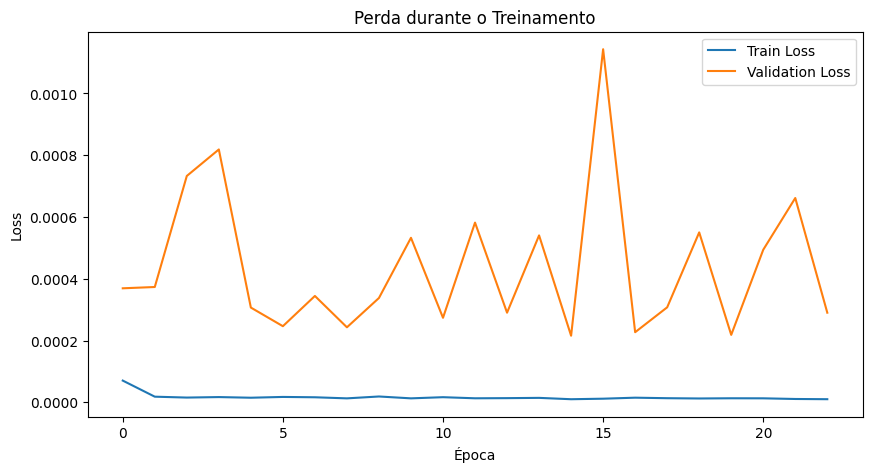

In [118]:
# Aumento de épocas e batch size
history = model.fit(
    X_train, y_train,
    epochs=300,          
    batch_size=16,       
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot da perda durante o treinamento
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()




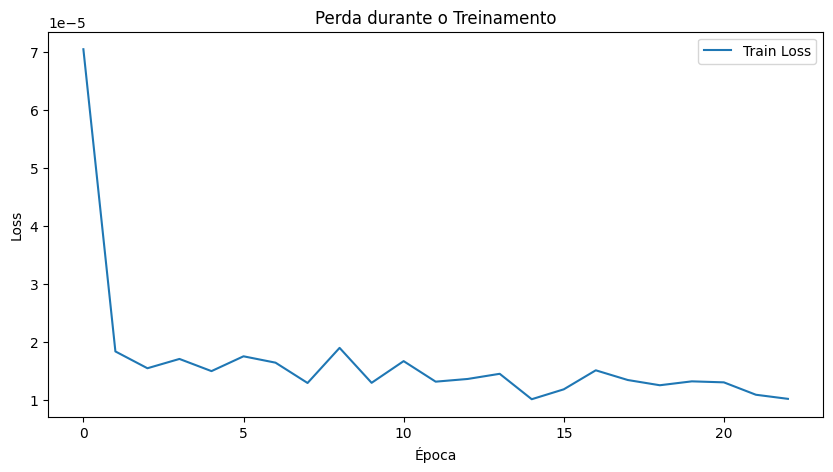

In [119]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Avaliação e Previsões

In [120]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverter a normalização
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])



28/28 [==============================] - 0s 2ms/step


In [121]:
# Deslocar as previsões de treino para alinhar visualmente
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[SEQ_LENGTH:len(train_predict)+SEQ_LENGTH, :] = train_predict

In [122]:
# Deslocar as previsões de teste
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(SEQ_LENGTH*2)+1:len(data)-1, :] = test_predict

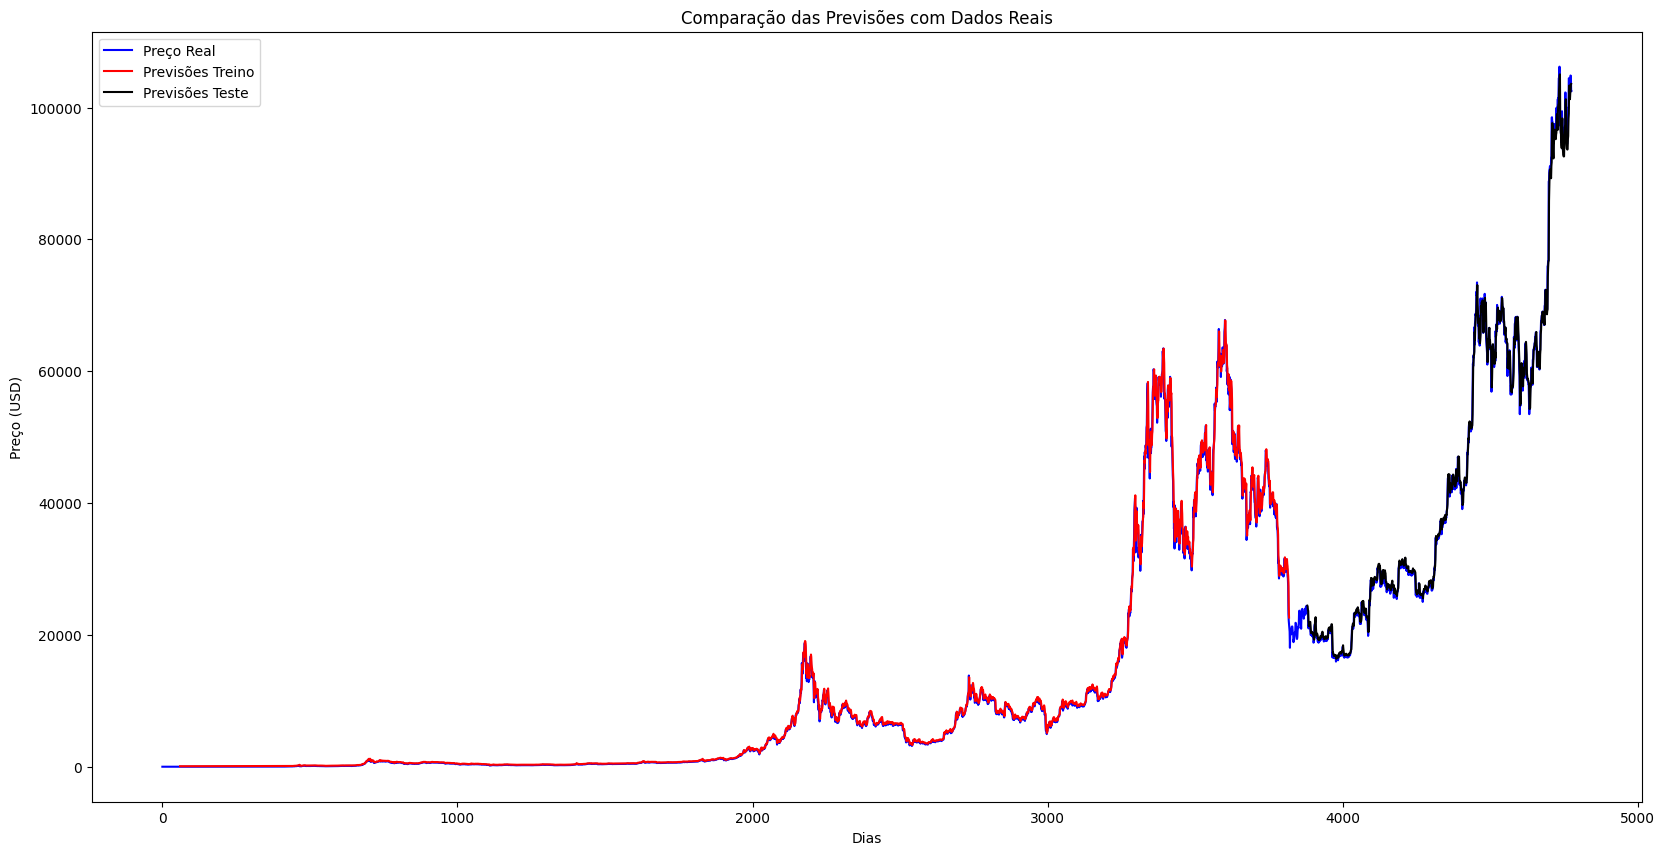

In [123]:
# Plotar tudo
# Plot dos resultados
plt.figure(figsize=(20,10))

plt.plot(data, label='Preço Real', color = 'blue')
plt.plot(train_plot, label='Previsões Treino', color = 'red')
plt.plot(test_plot, label='Previsões Teste', color= 'black')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

## Previsão Futura (Exemplo)

In [124]:
def predict_future(model, last_sequence, days=30):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Fazer previsão
        next_pred = model.predict(current_sequence.reshape(1, SEQ_LENGTH, 1))
        
        # Atualizar a sequência
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
        
        predictions.append(next_pred[0,0])
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1,1))


In [130]:
# Última sequência dos dados de teste
last_sequence = scaled_data[-SEQ_LENGTH:]

# Gerar previsões para 30 dias
future_predictions = predict_future(model, last_sequence, days=30)
print("Previsões para os próximos 30 dias:")
print(future_predictions)

1/1 [==============================] - 0s 24ms/step
Previsões para os próximos 30 dias:
[[101467.31 ]
 [100567.04 ]
 [ 99673.766]
 [ 98797.13 ]
 [ 97943.414]
 [ 97115.74 ]
 [ 96315.38 ]
 [ 95542.46 ]
 [ 94796.48 ]
 [ 94076.58 ]
 [ 93381.734]
 [ 92710.87 ]
 [ 92062.875]
 [ 91436.695]
 [ 90831.336]
 [ 90245.84 ]
 [ 89679.31 ]
 [ 89130.92 ]
 [ 88599.88 ]
 [ 88085.46 ]
 [ 87586.96 ]
 [ 87103.75 ]
 [ 86635.21 ]
 [ 86180.766]
 [ 85739.86 ]
 [ 85311.984]
 [ 84896.66 ]
 [ 84493.38 ]
 [ 84101.75 ]
 [ 83721.305]]


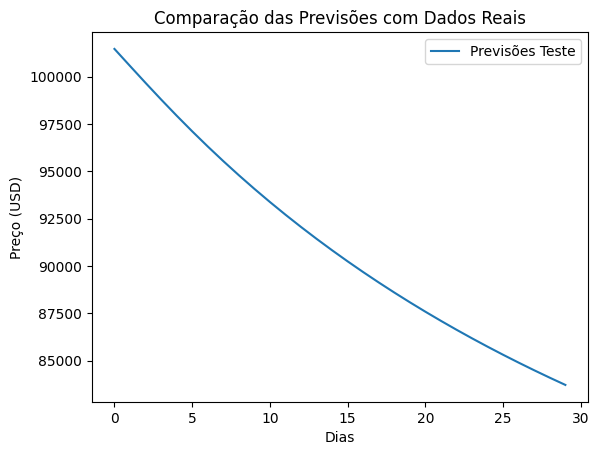

In [131]:
plt.plot(future_predictions, label='Previsões Teste')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()